# Import Libraries

In [303]:
import os 
from warnings import filterwarnings; filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load Datasets

In [304]:
path = "D:\project_py_web\FREELANCER\FP_\data\\".replace("\\","/")

In [305]:
for x in os.listdir("D:\project_py_web\FREELANCER\FP_\data".replace("\\","/")):
    print(x)

Bakkavor Group plc.csv
Concurrent Technologies plc.csv
Location Sciences Group PLC.csv
Tasty plc.csv


In [306]:
df1 = pd.read_csv(path+"Tasty plc.csv")
df2 = pd.read_csv(path+"Location Sciences Group PLC.csv")
df3 = pd.read_csv(path+"Bakkavor Group plc.csv")
df4 = pd.read_csv(path+"Concurrent Technologies plc.csv")

# Tasty PLC Dataset

# Task

1. Data evaluation and elementary preprocessing. Analyse completeness of data. Are there missed
data (besides weekends)? How many missed data points are in your time series? Are the dates of
missed values the same for all your time series? What may be the reasons for missing? How can you
handle the missed values in your data (explain at least three approaches)? Use the simple rule: fill in a
missed value by the closest in time past existing value. Plot the results. Normalise to the z-score (zero
mean and unit standard deviation). Plot the results. (15 marks) 

In [307]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    759 non-null    object 
 1   Close   759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [308]:
df1.describe()

,Close
count,759.000000
mean,8.474804
std,7.212084
min,1.250000
25%,2.750000
50%,4.500000
75%,14.774000
max,31.485500


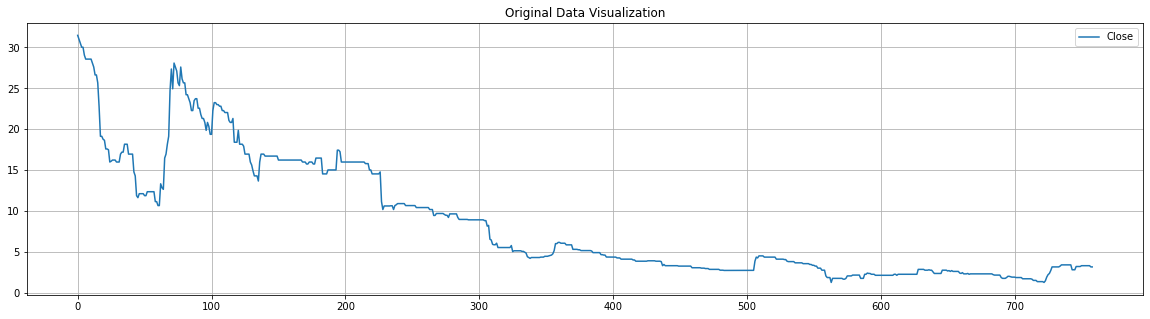

In [309]:
df1.plot(figsize=(20,5), grid=True, title="Original Data Visualization");

Are there missed data (besides weekends)?
How many missed data points are in your time series?

In [310]:
pd.date_range(start = '02-01-2018', end = '30-12-2020' ).difference(df1.index).isnull().sum()

0

Answer : No

Normalise to the z-score (zero mean and unit standard deviation). Plot the results.

In [311]:
# apply the z-score method in Pandas using the .mean() and .std() methods
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        try:
            df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        except Exception:
            pass
        
    return df_std

In [312]:
df1_norm = z_score(df1) 

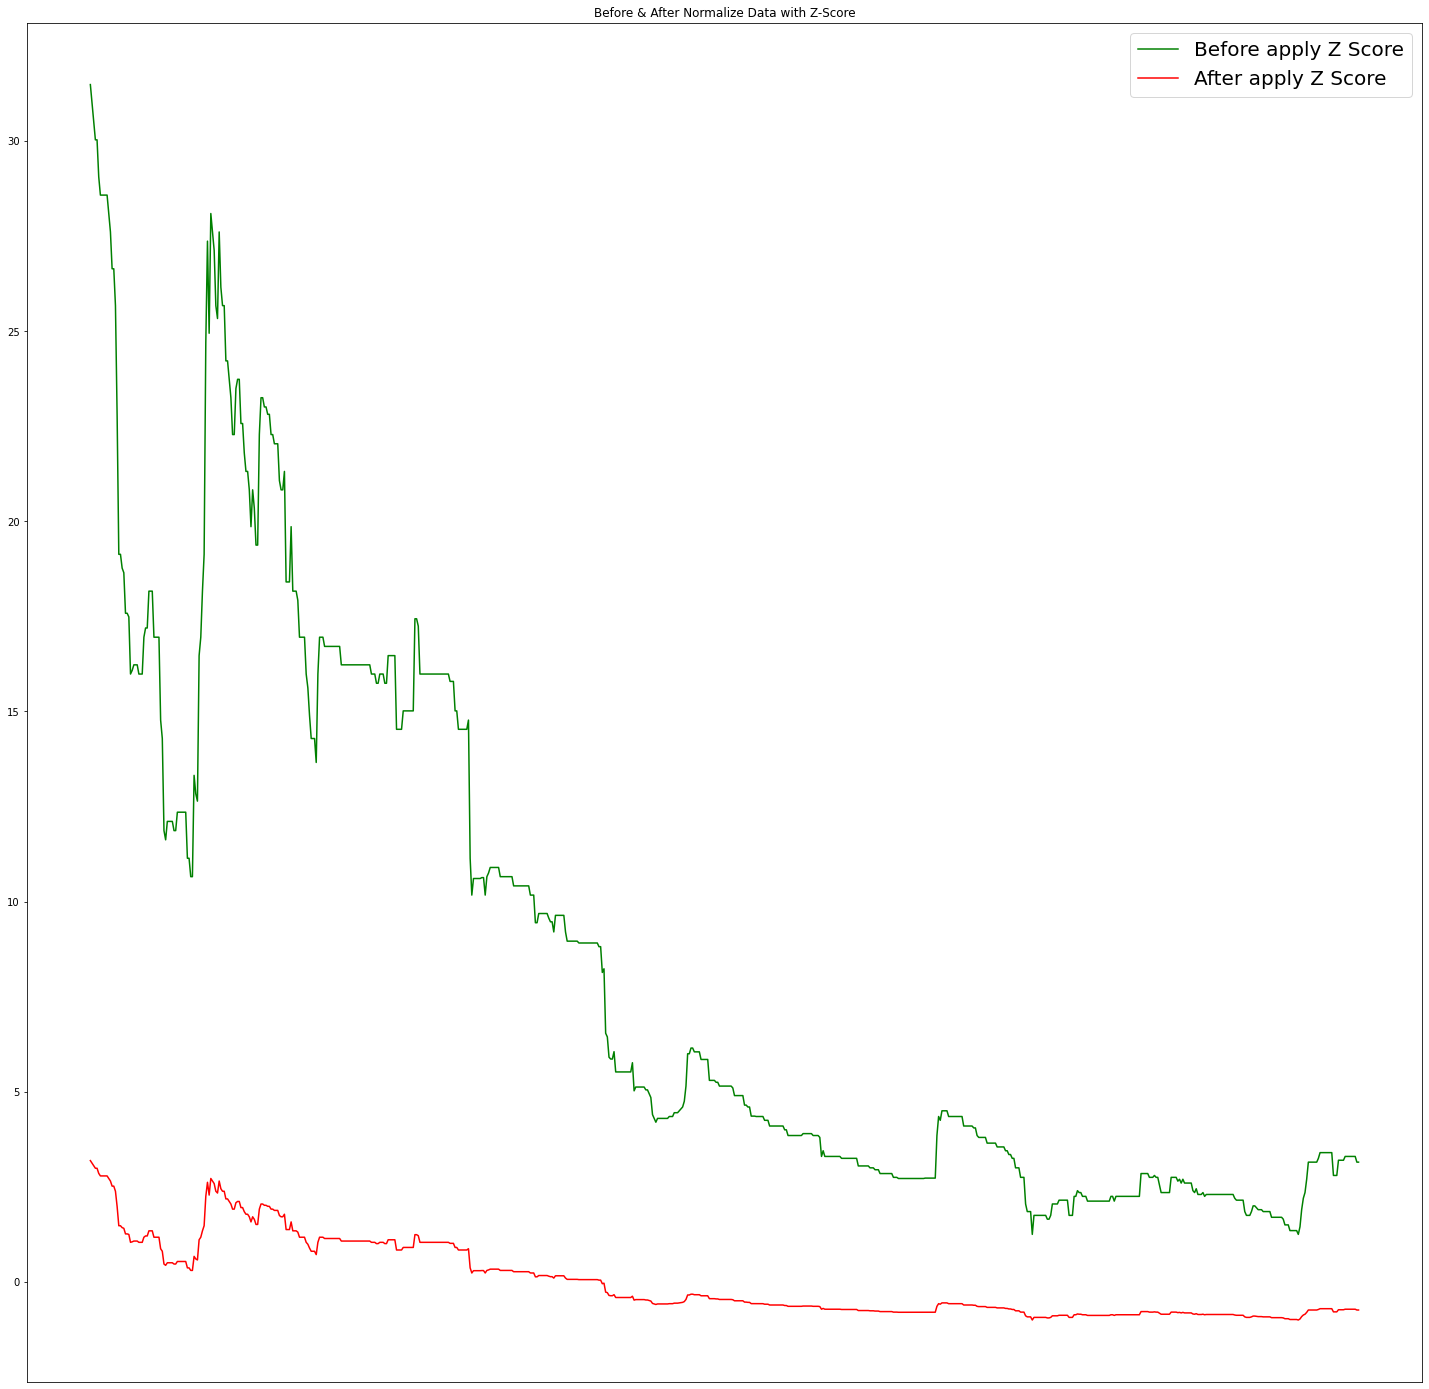

In [313]:
plt.figure(figsize=(25,25))
plt.plot(df1.Date, df1.Close, color="green", label="Before apply Z Score")
plt.plot(df1.Date, df1_norm.Close, color="red", label="After apply Z Score")
plt.legend(prop={'size': 20})
plt.title("Before & After Normalize Data with Z-Score")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False); # labels along the bottom edge are off

2. Segmentation. Prepare the bottom-up piecewise linear segmentation for the transformed and
normalised log-return time series. Use the following mean square errors tolerance levels: 1%, 5%, 10%
(the thresholds of the mean square errors). Plot the results. Are the segments similar for different time
series you analysed? (25 marks) 

 Prepare the bottom-up piecewise linear segmentation

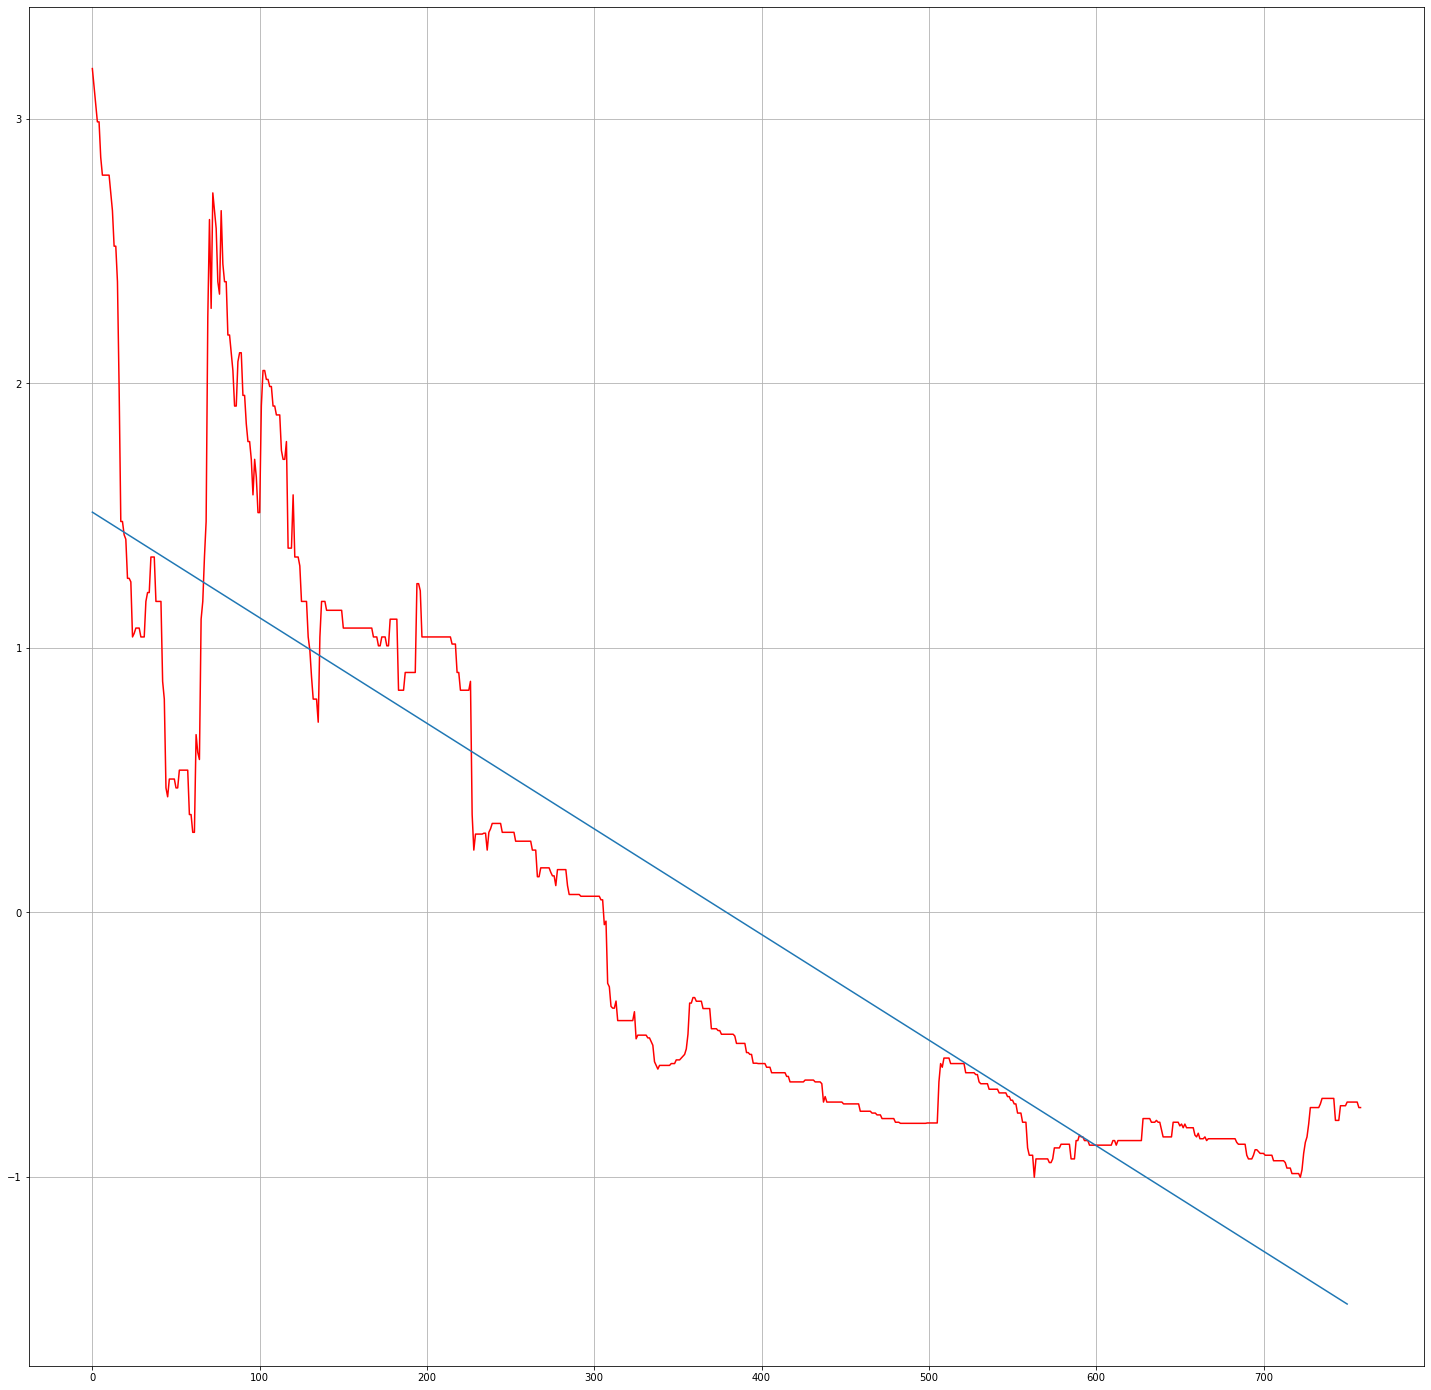

In [314]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

x = [x for x in range(len(df1.Date))]
y = df1_norm.Close

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 750, 100)
plt.figure(figsize=(25,25))
plt.plot(x, y, color="red")
plt.grid(True)
plt.plot(xd, piecewise_linear(xd, *p));

for the transformed and normalised log-return time series.

In [315]:
def to_integer(dt_time):
    return 10000*int(dt_time.split("/")[2]) + 100*int(dt_time.split("/")[1]) + int(dt_time.split("/")[0])

In [316]:
df1_norm.Date = [np.float32(to_integer(x)) for x in df1_norm.Date]

In [317]:
df1_norm.head(2)

,Date,Close
0,20180102.0,3.190575
1,20180104.0,3.123424


In [318]:
%matplotlib inline
import numpy as np
import pylab as pl
from scipy import optimize

def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

In [319]:
x = np.array([x for x in range(len(df1_norm.Date.astype(int)))])
y = np.array(df1_norm.Close)

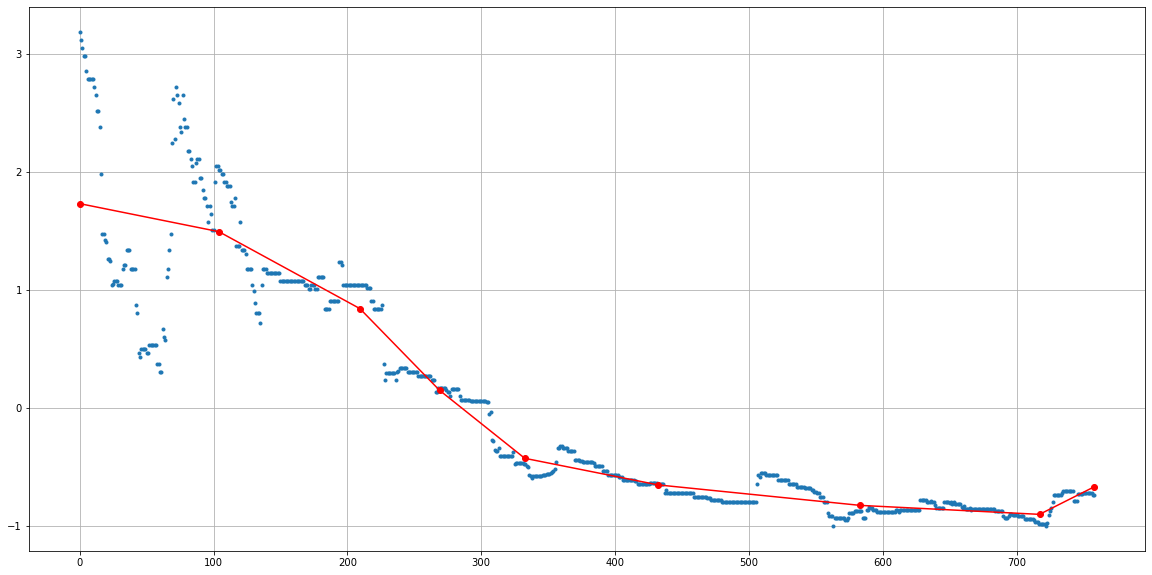

In [320]:
px, py = segments_fit(x, y, 8)
plt.figure(figsize=(20,10))
plt.grid(True)
pl.plot(x, y, ".")
pl.plot(px, py, "-or");

In [321]:
df1.Date = pd.to_datetime(df1.Date)

In [322]:
timeseries = df1.Date

In [323]:
X = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())

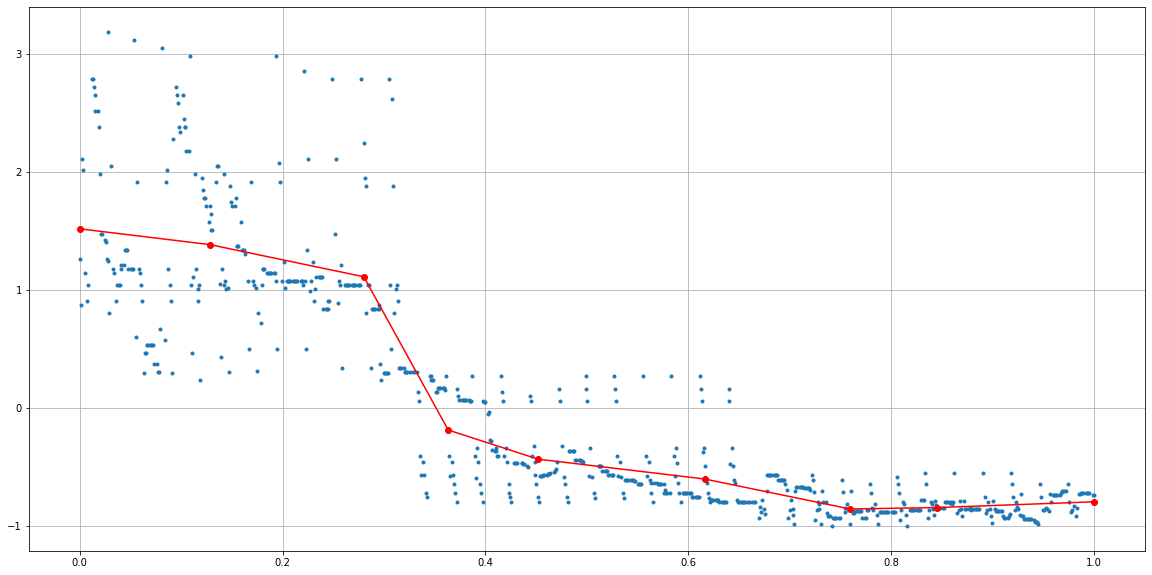

In [324]:
px, py = segments_fit(X, y, 8)
plt.figure(figsize=(20,10))
plt.grid(True)
pl.plot(X, y, ".")
pl.plot(px, py, "-or");

In [325]:
timeseries = df1_norm.Date

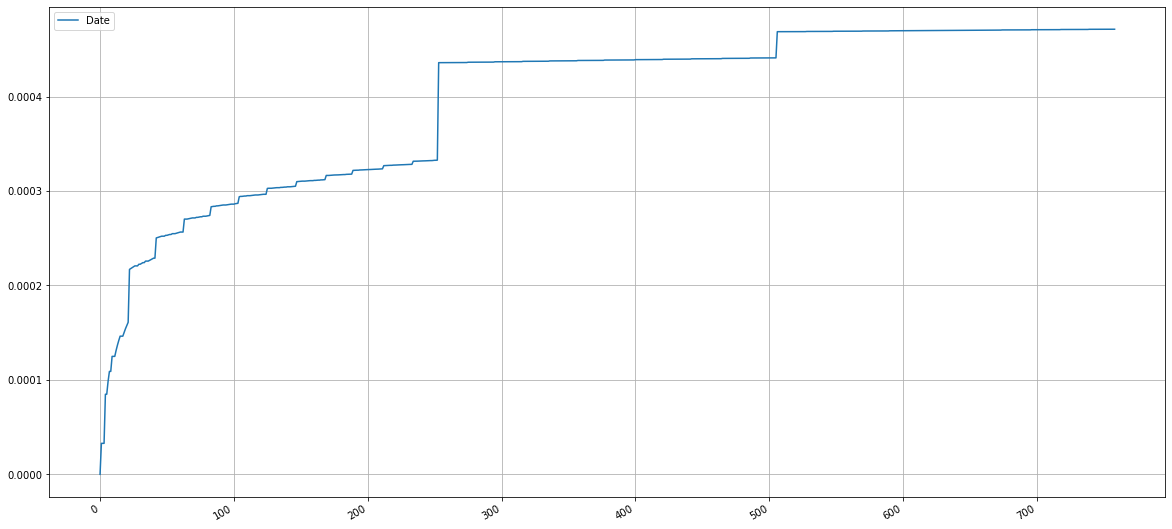

In [326]:
log = pd.DataFrame(np.log(timeseries-timeseries.min())/(timeseries.max()-timeseries.min()))

# Differencing the log values twice. 
log_diff = log.replace({np.nan:0,-np.inf:0})
log_diff.plot(subplots=True, figsize=(20,10), grid=True);

se the following mean square errors tolerance levels: 1%, 5%, 10% (the thresholds of the mean square errors).

In [327]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag= "BIC")
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num of Observations Used For ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [328]:
ad_test(log_diff["Date"])

1. ADF :  -6.909175193165739
2. P-Value :  1.224913506977124e-09
3. Num Of Lags :  0
4. Num of Observations Used For ADF Regression and Critical Values Calculation :  758
5. Critical Values : 
	 1% :  -3.439006442437876
	 5% :  -2.865360521688131
	 10% :  -2.5688044403756587


In [339]:
final_df_1 = pd.DataFrame({"date_log":log_diff["Date"],
                           "close_zscore":y})

In [340]:
final_df_1

,date_log,close_zscore
0,0.000000,3.190575
1,0.000033,3.123424
2,0.000033,3.056259
3,0.000033,2.989094
4,0.000085,2.989094
...,...,...
754,0.000471,-0.717519
755,0.000471,-0.717519
756,0.000471,-0.717519
757,0.000471,-0.738317


In [341]:
n_obs = 100
train, test = final_df_1[:-n_obs], final_df_1[-n_obs:]

In [342]:
# Fitting the VAR model
from statsmodels.tsa.api import VAR

model = VAR(final_df_1)
results = model.fit(maxlags = 25, ic = 'aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, May, 2021
Time:                     18:44:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -29.5581
Nobs:                     747.000    HQIC:                  -29.7480
Log likelihood:           9085.47    FPE:                1.06882e-13
AIC:                     -29.8671    Det(Omega_mle):     1.00072e-13
--------------------------------------------------------------------
Results for equation date_log
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000008         0.000002            3.775           0.000
L1.date_log              0.973472         0.037212           26.160           0.000
L1.close_zscore          0.000000         0.0

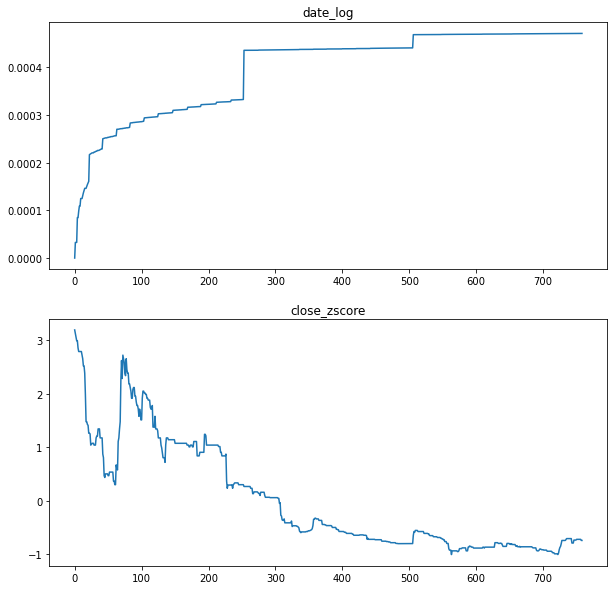

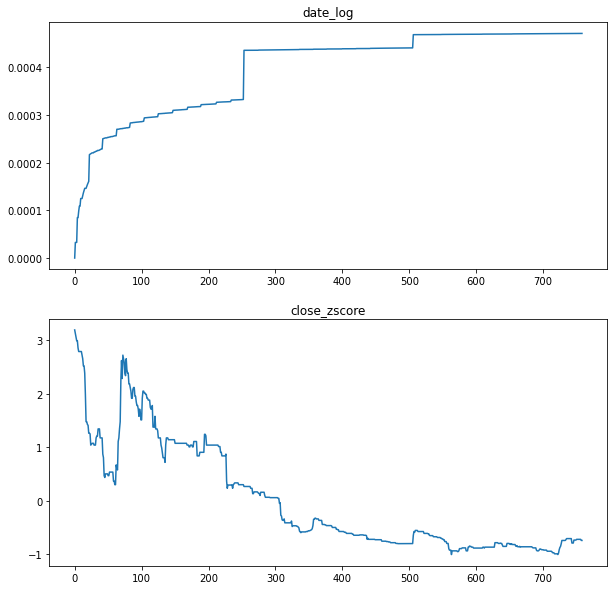

In [343]:
results.plot()

In [344]:
final_df_1["datetime_std"] =  X

In [345]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
close_scaled = scale.fit_transform(df1.Close.values.reshape(-1,1))

In [346]:
final_df_1["close_scale"] = close_scaled

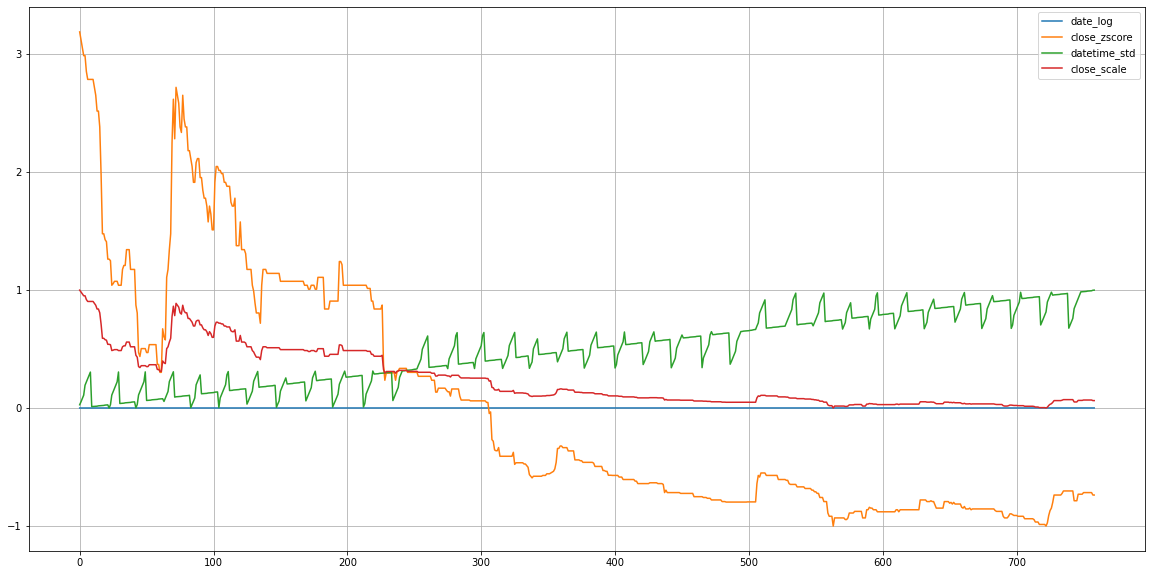

In [347]:
final_df_1.plot(figsize=(20,10), grid=True);

 Are the segments similar for different time series you analysed?

Yes

3. Prediction. Chose one of the transformed and normalised time series as a target 𝑔(𝑡) and other 3 as
supporting data 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡), where 𝑡 = 1, … , 𝑇. Provide scatter diagrams of (g(t),g(t+1)).
Evaluate the error of the “next-day forecast”, 𝑔̂(𝑡 + 1) = 𝑔(𝑡).
Use data for 2018 as the training set and find the predictor of 𝑔(𝑡 + 1) (the next day value) as a
linear function Ψ of 𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡):
𝑔̂(𝑡 + 1) = Ψ(𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡)) (1)
(linear regression). Evaluate the training set error. Use data for 2019 as a test set and evaluate the test
set error for this set. Also, use data for 2020 as a test set and evaluate the test set error for this set.
Compare these errors. Compare these errors to the errors of the “next-day forecast”. Comment.
Provide plots of 𝑔(𝑡), 𝑔̂(𝑡), and the residual. Present the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram. (30 marks) 

In [452]:
final_df_1["Date"] = df1_norm.Date.astype(int).astype(str).apply(lambda x: x[0:4])

In [454]:
final_df_1.head()

,date_log,close_zscore,datetime_std,close_scale,Date
0,0.000000,3.190575,0.027447,1.000000,2018
1,0.000033,3.123424,0.053065,0.983982,2018
2,0.000033,3.056259,0.081427,0.967962,2018
3,0.000033,2.989094,0.108875,0.951941,2018
4,0.000085,2.989094,0.193047,0.951941,2018


Use data for 2018 as the training set and find the predictor of 𝑔(𝑡 + 1) (the next day value) as a linear function Ψ of 𝑔(𝑡), 𝑑1 (𝑡), 𝑑2 (𝑡), 𝑑3 (𝑡): 𝑔̂(𝑡 + 1) = Ψ(𝑔(𝑡), 𝑑1 (𝑡), 𝑑2 (𝑡), 𝑑3 (𝑡)) (1) (linear regression).

In [458]:
train = final_df_1.loc[final_df_1["Date"] == "2018"]
test  = final_df_1.loc[final_df_1["Date"] != "2018"] 

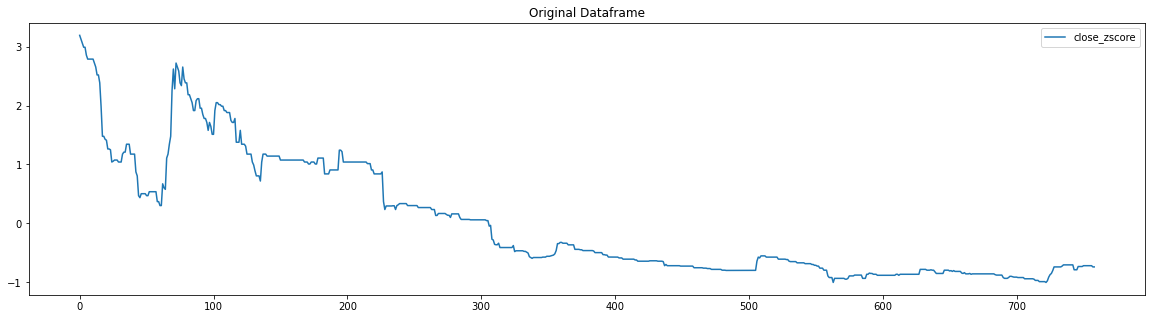

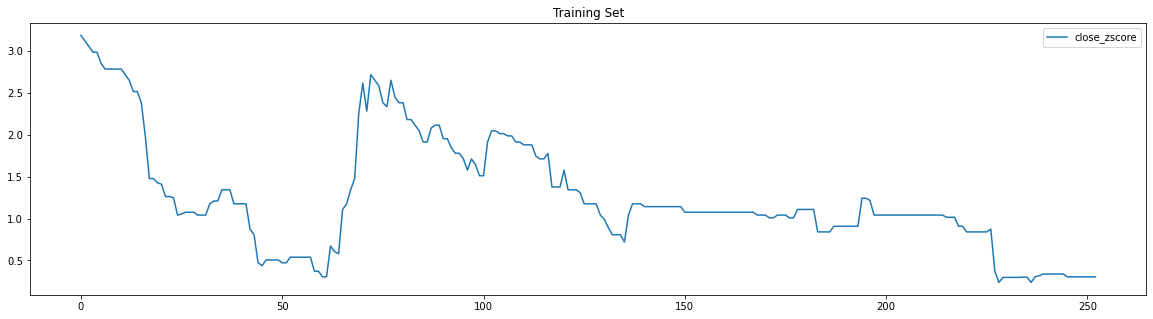

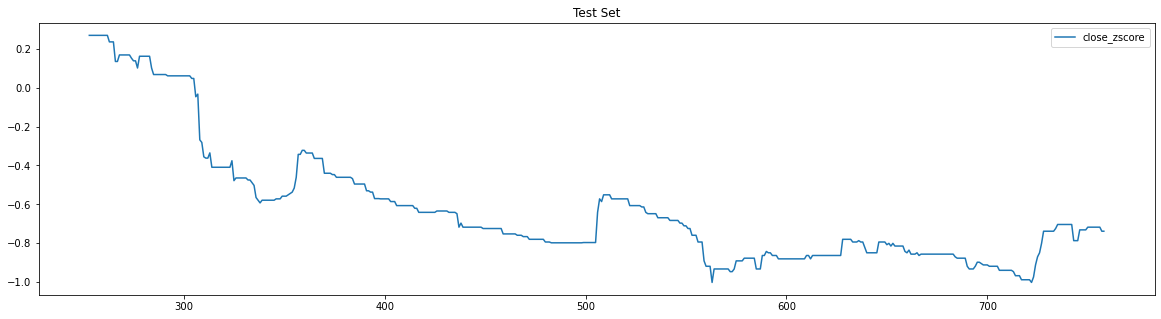

In [469]:
final_df_1.plot(y="close_zscore", figsize=(20,5),title="Original Dataframe")
train.plot(y="close_zscore", figsize=(20,5),title="Training Set")
test.plot(y="close_zscore", figsize=(20,5),title="Test Set");

In [488]:
# function to evaulate performance of the regressor. 
from sklearn.metrics import *
def evaulation(model, y_pred, y_true):
    
    '''
    Input:- model = string (Name of the regressor)
    y_pred= model prediction
    y_true = actual labels. 
    
    Output:
    Dataframe with evaulation matrix. 
    
    '''
    
    # create data output frame for the evaluation. 
    data = [explained_variance_score(y_true,y_pred), 
            max_error(y_true,y_pred),
            mean_squared_error(y_true,y_pred),
            mean_absolute_error(y_true,y_pred),
            r2_score(y_true,y_pred, multioutput='uniform_average'),
            median_absolute_error(y_true,y_pred)           
            ]
    row_index = ['Exp_Var_Score', 'Max_Error','MSE','MAE','R2_Score', 'Median_Abs_Error']
    
    df = pd.DataFrame(data, columns= [model], index= row_index)
    
    return df

In [489]:
X = train[['date_log', 'datetime_std', 'close_scale']]
Y = train['close_zscore'].values

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [491]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict the test data
y_pred_lr_new = lr.predict(X_test)

#evaulation of the lr   
print('Intercept:', lr.intercept_)
print('Coefficients:', lr.coef_)

Intercept: -1.0017637069358056
Coefficients: [-1.28087348e-12  1.33226763e-15  4.19233859e+00]


In [492]:
# Linear regressor evaulation parameters
df_linear = evaulation('linear', y_pred_lr_new, y_test)
df_linear

,linear
Exp_Var_Score,1.000000e+00
Max_Error,8.881784e-16
MSE,2.234890e-31
MAE,4.250986e-16
R2_Score,1.000000e+00
Median_Abs_Error,4.163336e-16


Use data for 2019 as a test set and evaluate the test set error for this set. Also, use data for 2020 as a test set and evaluate the test set error for this set. Compare these errors.

In [493]:
# predict 2019-2020
x = test[['date_log', 'datetime_std', 'close_scale']]
y = test['close_zscore'].values

In [494]:
new_preds = lr.predict(x)

In [496]:
# Linear regressor evaulation parameters
df_linear = evaulation('linear', new_preds, y)
df_linear

,linear
Exp_Var_Score,1.000000e+00
Max_Error,9.992007e-16
MSE,2.655408e-31
MAE,4.770284e-16
R2_Score,1.000000e+00
Median_Abs_Error,4.440892e-16


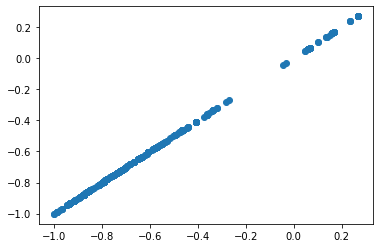

In [495]:
plt.scatter(y, new_preds);

Provide plots of 𝑔(𝑡), 𝑔̂(𝑡), and the residual. Present the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram. (30 marks)

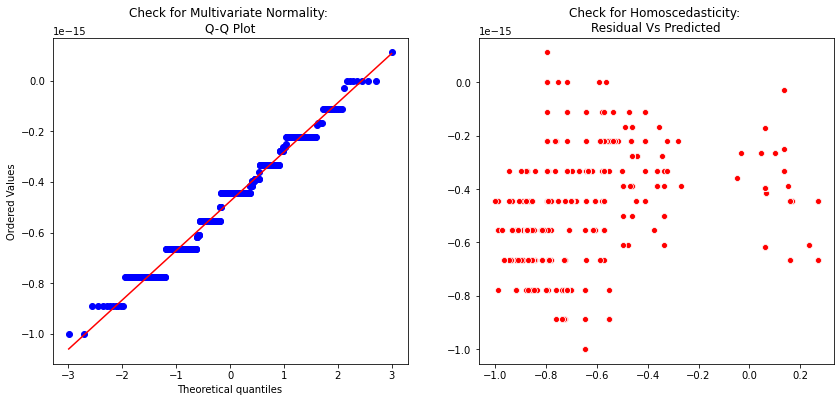

In [498]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y - new_preds),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y - new_preds), x= new_preds, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Answer : based on suggestions from questions, I trained my linear regression model using data from 2018, then made predictions for the next 2 years (2019 & 2020). As seen in the residual visualization above, my model can predict accurately.

4. Adaptive predictors. For each given value of the “frame width”, Δ=5, 10, 30, create and test the
following adaptive predictor. For every T> Δ create the training set with Δ input vectors
(𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡)) (𝑡 = 𝑇 − Δ, … , 𝑇-1) and the corresponding outputs 𝑔(𝑡 + 1).
In more detail, the input vectors 𝒙𝑖
 and the output values 𝑦𝑖
 for a given T are
𝒙1 = (𝑔(𝑇 − Δ), 𝑑1
(𝑇 − Δ), 𝑑2
(𝑇 − Δ), 𝑑3
(𝑇 − Δ)), 𝑦1 = 𝑔(𝑇 − Δ + 1)
………..
𝒙𝑖 = (𝑔(𝑇 − Δ + 𝑖 − 1), 𝑑1
(𝑇 − Δ + 𝑖 − 1), 𝑑2
(𝑇 − Δ + 𝑖 − 1), 𝑑3
(𝑇 − Δ + 𝑖 − 1)),
𝑦𝑖 = 𝑔(𝑇 − Δ + 𝑖)
Where i=1,2,…, Δ.
Find the linear regression (1) for each T> Δ. Test this linear regression for the next time value, t=T+1.
In more detail, for each T there is one test example with the input vector 𝒙𝑡𝑒𝑠𝑡 and output value 𝑦𝑡𝑒𝑠𝑡:
𝒙𝑡𝑒𝑠𝑡 = (𝑔(𝑇), 𝑑1
(𝑇), 𝑑2
(𝑇), 𝑑3
(𝑇)), 𝑦𝑡𝑒𝑠𝑡 = 𝑔(𝑇 + 1)
Please pay attention that this example does not belong to a training set for this value of T.
 Find the residuals at these test time moments. Plot these residuals and the values 𝑔(𝑡), 𝑔̂(𝑡). Present
the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram (t=T+1). Calculate the mean square error. Compare to the previous
task. Comment. (30 marks) 

In [474]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

In [475]:
# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

In [476]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,-1.001764e+00,-1.001764e+00
1,theta_1,date_log,-2.910383e-10,-1.280873e-12
2,theta_2,datetime_std,6.394885e-14,1.332268e-15
3,theta_3,close_scale,4.192339e+00,4.192339e+00


In [477]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  3.8601604441053127e-28
R square obtain for normal equation method is : 1.0


In [478]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse_sk)
print('R square obtain for scikit learn library is :',R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  2.2348896533605146e-31
R square obtain for scikit learn library is : 1.0


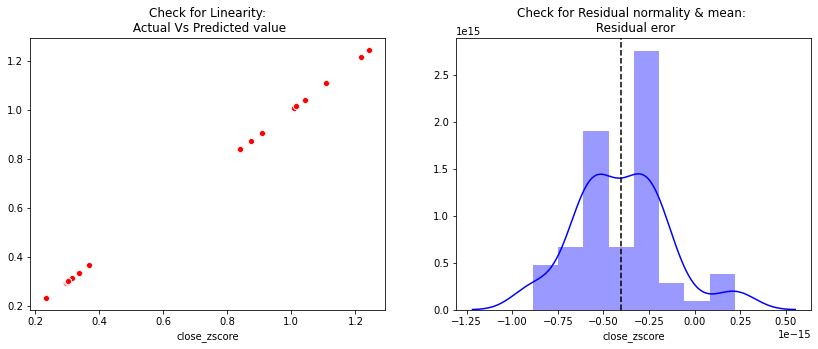

In [479]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

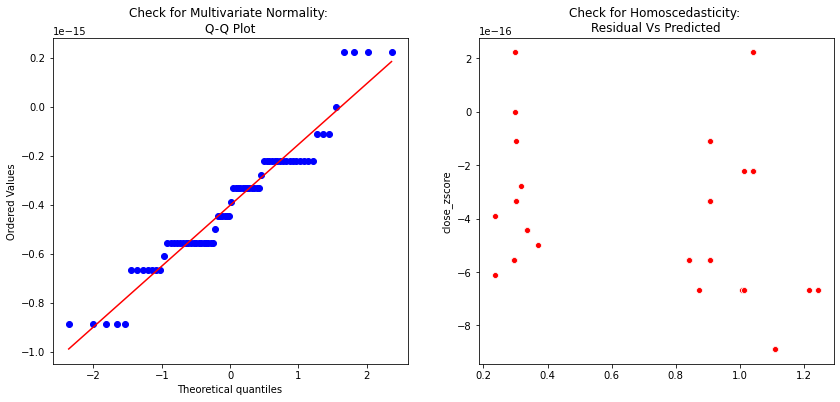

In [480]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Conclusion, based on the comparison of the residual visualization results on task 3 and 4, the visualization is the same

# Location Sciences Group PLC Dataset

# Task

1. Data evaluation and elementary preprocessing. Analyse completeness of data. Are there missed
data (besides weekends)? How many missed data points are in your time series? Are the dates of
missed values the same for all your time series? What may be the reasons for missing? How can you
handle the missed values in your data (explain at least three approaches)? Use the simple rule: fill in a
missed value by the closest in time past existing value. Plot the results. Normalise to the z-score (zero
mean and unit standard deviation). Plot the results. (15 marks) 

In [499]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    759 non-null    object 
 1   Close   759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [500]:
df2.describe()

,Close
count,759.000000
mean,1.957735
std,1.023438
min,0.325000
25%,0.625000
50%,2.225000
75%,2.585200
max,4.400000


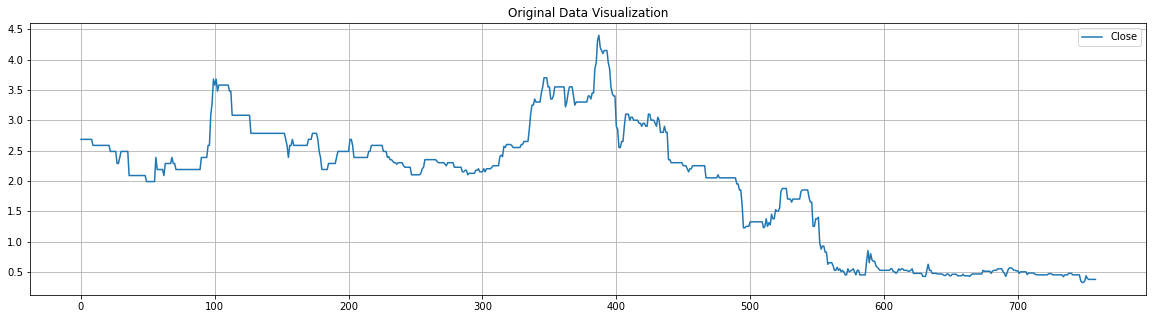

In [501]:
df2.plot(figsize=(20,5), grid=True, title="Original Data Visualization");

Are there missed data (besides weekends)?
How many missed data points are in your time series?

In [502]:
pd.date_range(start = '02-01-2018', end = '30-12-2020' ).difference(df1.index).isnull().sum()

0

Answer : No

Normalise to the z-score (zero mean and unit standard deviation). Plot the results.

In [503]:
df1_norm = z_score(df2) 

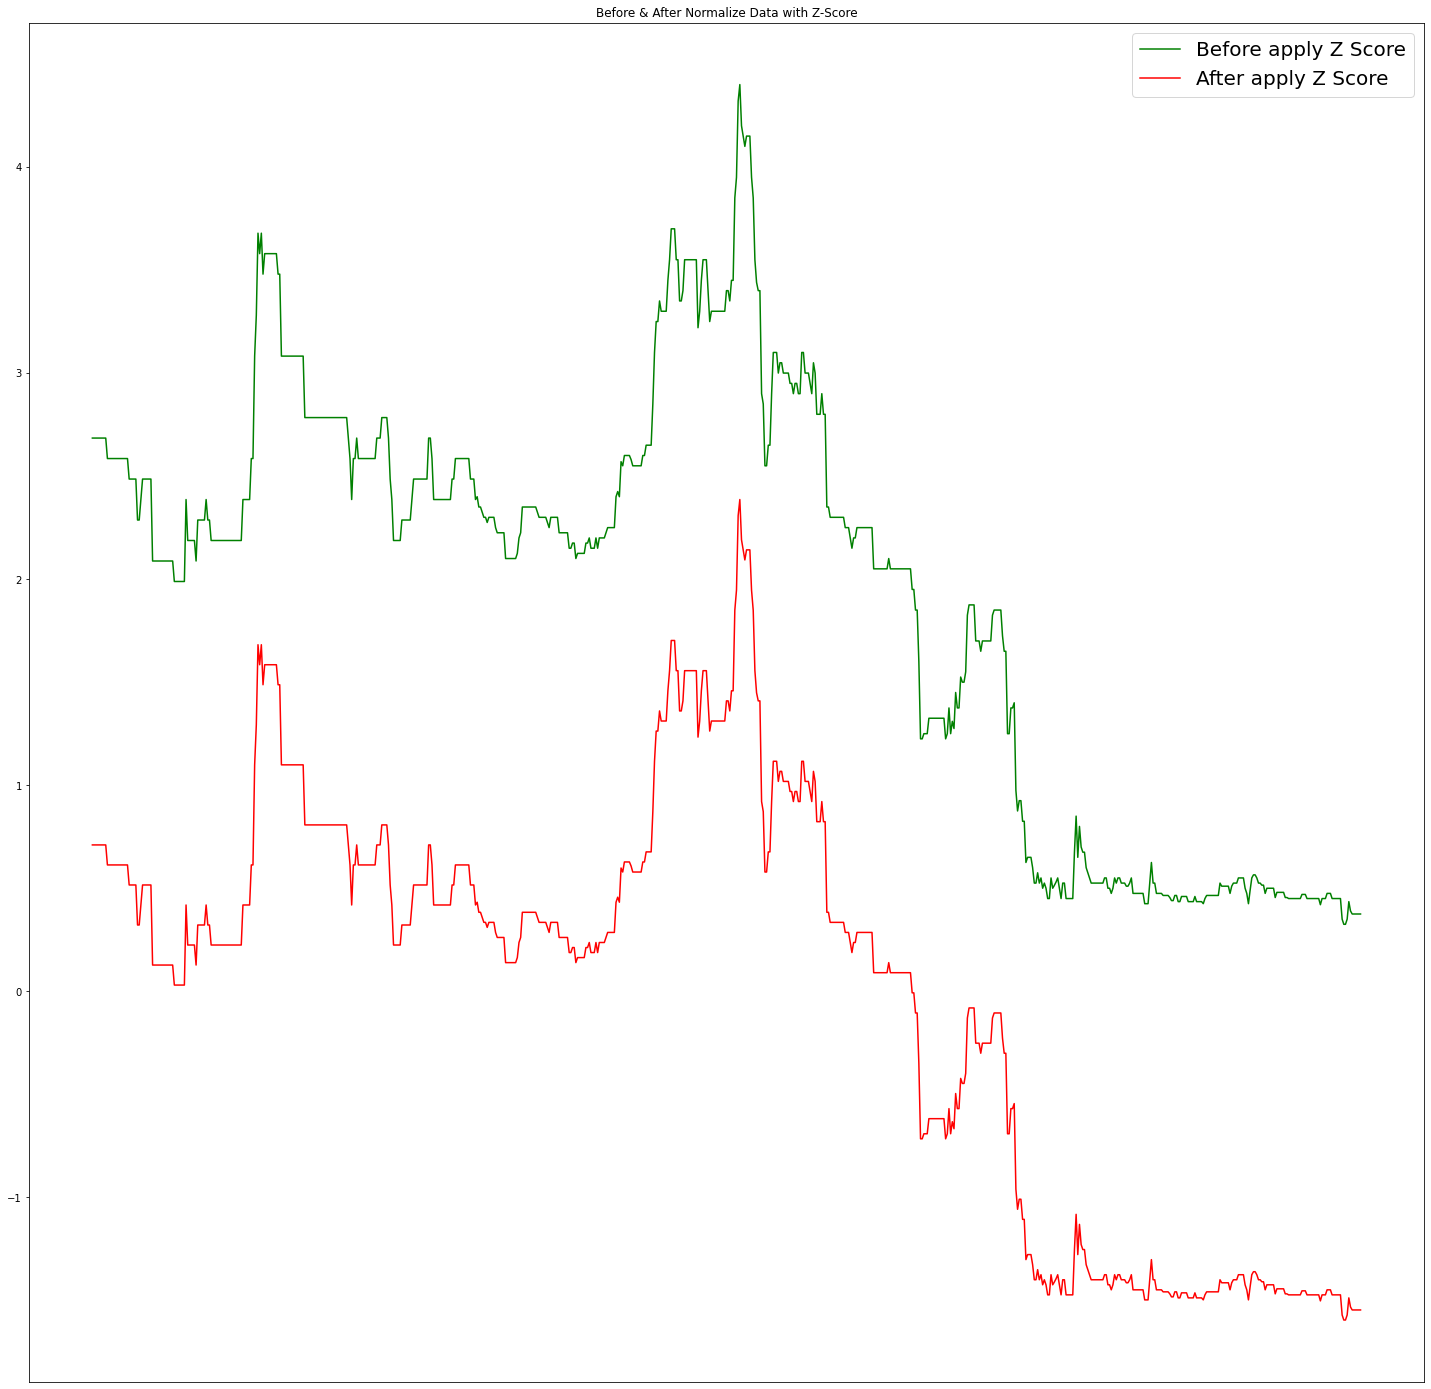

In [504]:
plt.figure(figsize=(25,25))
plt.plot(df2.Date, df2.Close, color="green", label="Before apply Z Score")
plt.plot(df2.Date, df1_norm.Close, color="red", label="After apply Z Score")
plt.legend(prop={'size': 20})
plt.title("Before & After Normalize Data with Z-Score")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False); # labels along the bottom edge are off

2. Segmentation. Prepare the bottom-up piecewise linear segmentation for the transformed and
normalised log-return time series. Use the following mean square errors tolerance levels: 1%, 5%, 10%
(the thresholds of the mean square errors). Plot the results. Are the segments similar for different time
series you analysed? (25 marks) 

 Prepare the bottom-up piecewise linear segmentation

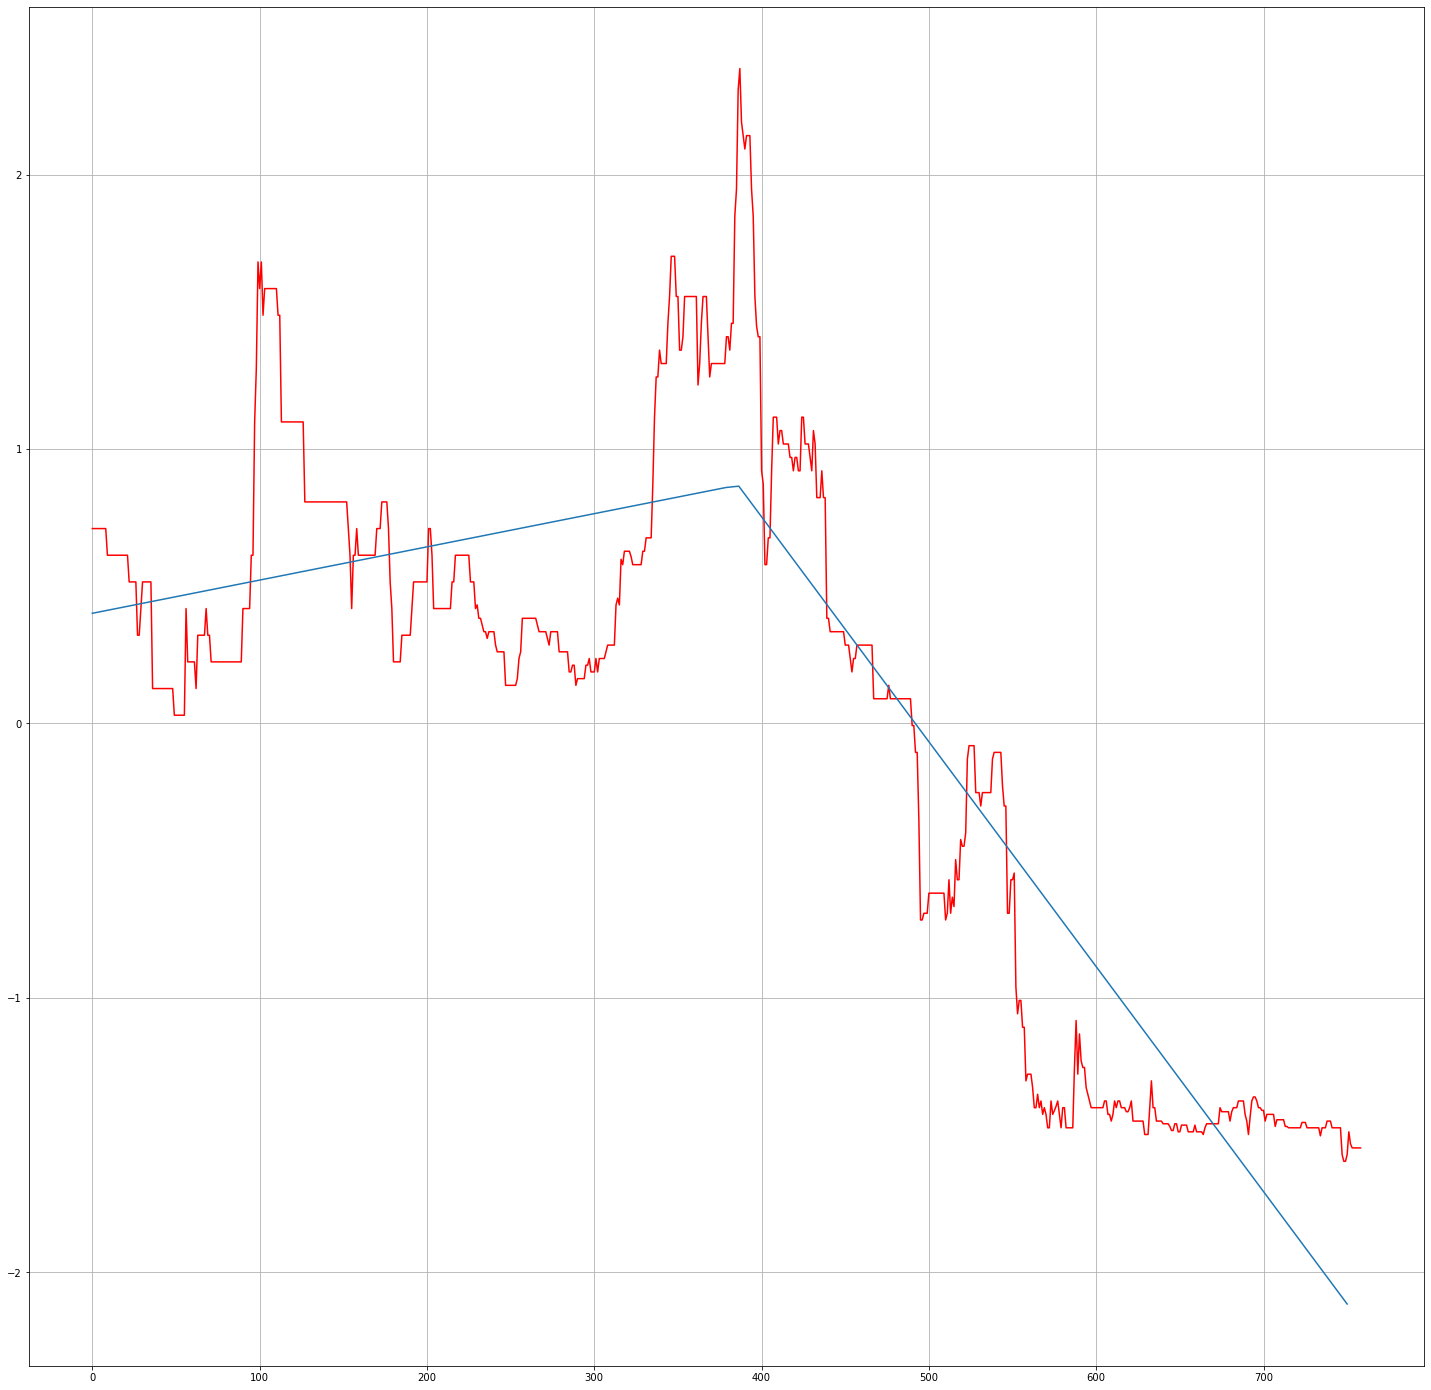

In [505]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

x = [x for x in range(len(df2.Date))]
y = df1_norm.Close

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 750, 100)
plt.figure(figsize=(25,25))
plt.plot(x, y, color="red")
plt.grid(True)
plt.plot(xd, piecewise_linear(xd, *p));

for the transformed and normalised log-return time series.

In [506]:
def to_integer(dt_time):
    return 10000*int(dt_time.split("/")[2]) + 100*int(dt_time.split("/")[1]) + int(dt_time.split("/")[0])

In [507]:
df1_norm.Date = [np.float32(to_integer(x)) for x in df1_norm.Date]

In [508]:
df1_norm.head(2)

,Date,Close
0,20180102.0,0.710219
1,20180104.0,0.710219


In [510]:
x = np.array([x for x in range(len(df1_norm.Date.astype(int)))])
y = np.array(df1_norm.Close)

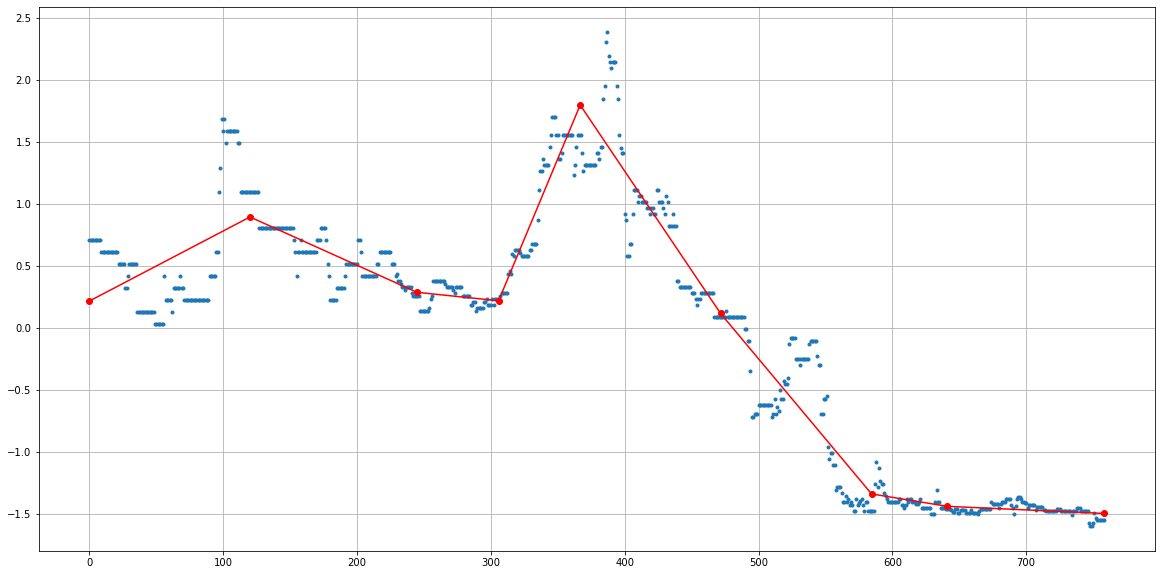

In [511]:
px, py = segments_fit(x, y, 8)
plt.figure(figsize=(20,10))
plt.grid(True)
pl.plot(x, y, ".")
pl.plot(px, py, "-or");

In [572]:
df1.Date = pd.to_datetime(df2.Date)

In [573]:
timeseries = df1.Date

In [574]:
X = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())

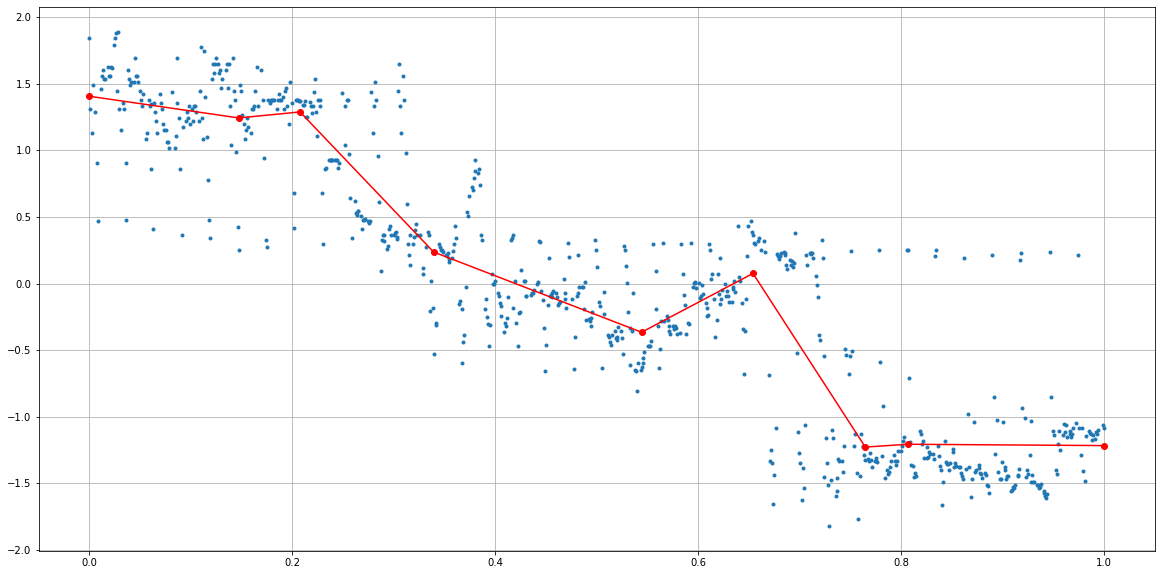

In [575]:
px, py = segments_fit(X, y, 8)
plt.figure(figsize=(20,10))
plt.grid(True)
pl.plot(X, y, ".")
pl.plot(px, py, "-or");

In [516]:
timeseries = df1_norm.Date

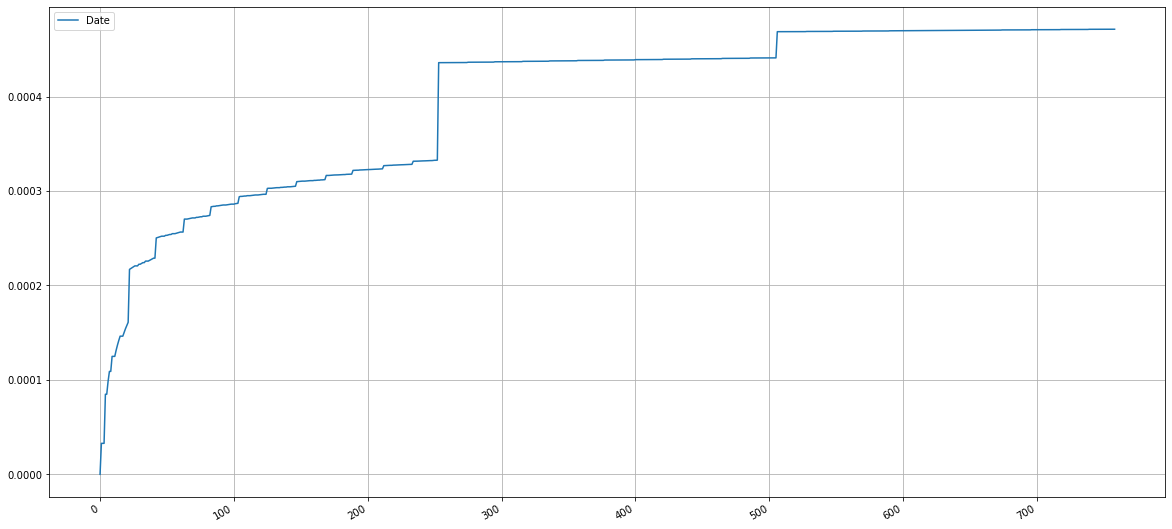

In [517]:
log = pd.DataFrame(np.log(timeseries-timeseries.min())/(timeseries.max()-timeseries.min()))

# Differencing the log values twice. 
log_diff = log.replace({np.nan:0,-np.inf:0})
log_diff.plot(subplots=True, figsize=(20,10), grid=True);

se the following mean square errors tolerance levels: 1%, 5%, 10% (the thresholds of the mean square errors).

In [518]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag= "BIC")
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num of Observations Used For ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [519]:
ad_test(log_diff["Date"])

1. ADF :  -6.909175193165739
2. P-Value :  1.224913506977124e-09
3. Num Of Lags :  0
4. Num of Observations Used For ADF Regression and Critical Values Calculation :  758
5. Critical Values : 
	 1% :  -3.439006442437876
	 5% :  -2.865360521688131
	 10% :  -2.5688044403756587


In [520]:
final_df_1 = pd.DataFrame({"date_log":log_diff["Date"],
                           "close_zscore":y})

In [521]:
final_df_1

,date_log,close_zscore
0,0.000000,0.710219
1,0.000033,0.710219
2,0.000033,0.710219
3,0.000033,0.710219
4,0.000085,0.710219
...,...,...
754,0.000471,-1.546487
755,0.000471,-1.546487
756,0.000471,-1.546487
757,0.000471,-1.546487


In [522]:
n_obs = 100
train, test = final_df_1[:-n_obs], final_df_1[-n_obs:]

In [523]:
# Fitting the VAR model
from statsmodels.tsa.api import VAR

model = VAR(final_df_1)
results = model.fit(maxlags = 25, ic = 'aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, May, 2021
Time:                     22:06:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -29.4533
Nobs:                     756.000    HQIC:                  -29.5060
Log likelihood:           9034.32    FPE:                1.48376e-13
AIC:                     -29.5390    Det(Omega_mle):     1.45666e-13
--------------------------------------------------------------------
Results for equation date_log
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.000006         0.000001            6.620           0.000
L1.date_log             0.963490         0.036519           26.383           0.000
L1.close_zscore        -0.000000         0.000002

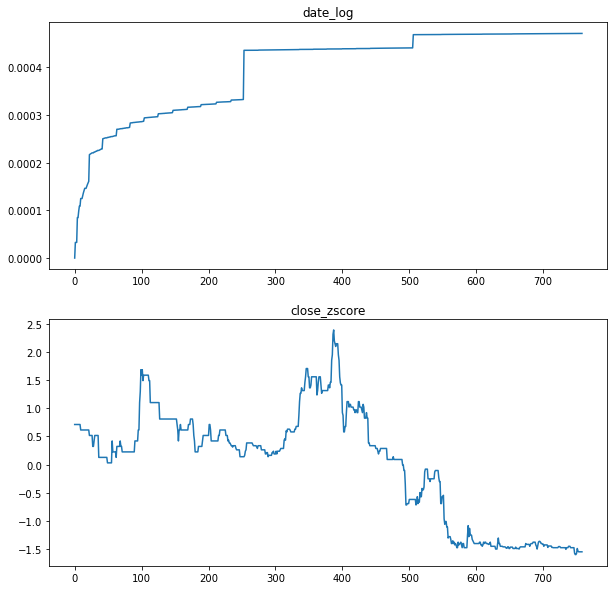

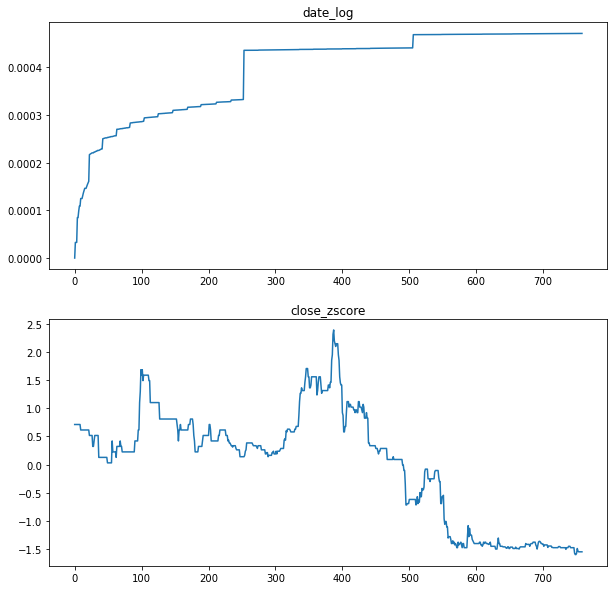

In [524]:
results.plot()

In [525]:
final_df_1["datetime_std"] =  X

In [526]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
close_scaled = scale.fit_transform(df1.Close.values.reshape(-1,1))

In [527]:
final_df_1["close_scale"] = close_scaled

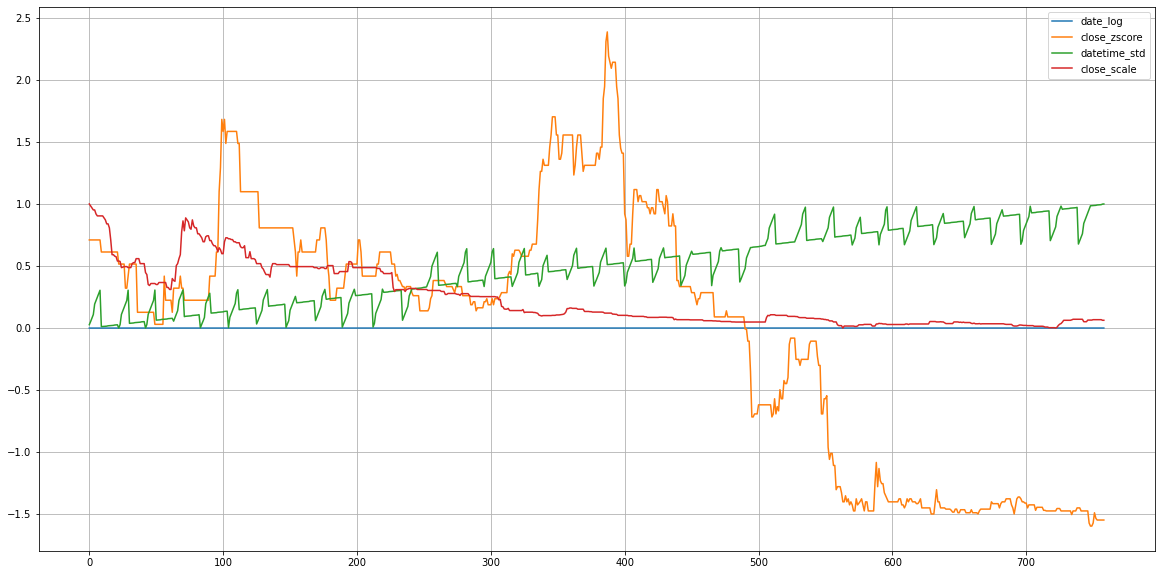

In [528]:
final_df_1.plot(figsize=(20,10), grid=True);

 Are the segments similar for different time series you analysed?

Yes

3. Prediction. Chose one of the transformed and normalised time series as a target 𝑔(𝑡) and other 3 as
supporting data 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡), where 𝑡 = 1, … , 𝑇. Provide scatter diagrams of (g(t),g(t+1)).
Evaluate the error of the “next-day forecast”, 𝑔̂(𝑡 + 1) = 𝑔(𝑡).
Use data for 2018 as the training set and find the predictor of 𝑔(𝑡 + 1) (the next day value) as a
linear function Ψ of 𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡):
𝑔̂(𝑡 + 1) = Ψ(𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡)) (1)
(linear regression). Evaluate the training set error. Use data for 2019 as a test set and evaluate the test
set error for this set. Also, use data for 2020 as a test set and evaluate the test set error for this set.
Compare these errors. Compare these errors to the errors of the “next-day forecast”. Comment.
Provide plots of 𝑔(𝑡), 𝑔̂(𝑡), and the residual. Present the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram. (30 marks) 

In [529]:
final_df_1["Date"] = df1_norm.Date.astype(int).astype(str).apply(lambda x: x[0:4])

In [530]:
final_df_1.head()

,date_log,close_zscore,datetime_std,close_scale,Date
0,0.000000,0.710219,0.027447,1.000000,2018
1,0.000033,0.710219,0.053065,0.983982,2018
2,0.000033,0.710219,0.081427,0.967962,2018
3,0.000033,0.710219,0.108875,0.951941,2018
4,0.000085,0.710219,0.193047,0.951941,2018


Use data for 2018 as the training set and find the predictor of 𝑔(𝑡 + 1) (the next day value) as a linear function Ψ of 𝑔(𝑡), 𝑑1 (𝑡), 𝑑2 (𝑡), 𝑑3 (𝑡): 𝑔̂(𝑡 + 1) = Ψ(𝑔(𝑡), 𝑑1 (𝑡), 𝑑2 (𝑡), 𝑑3 (𝑡)) (1) (linear regression).

In [531]:
train = final_df_1.loc[final_df_1["Date"] == "2018"]
test  = final_df_1.loc[final_df_1["Date"] != "2018"] 

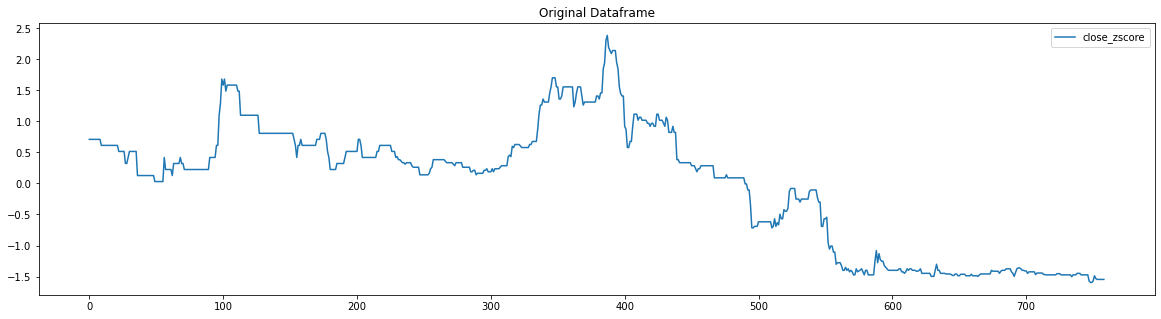

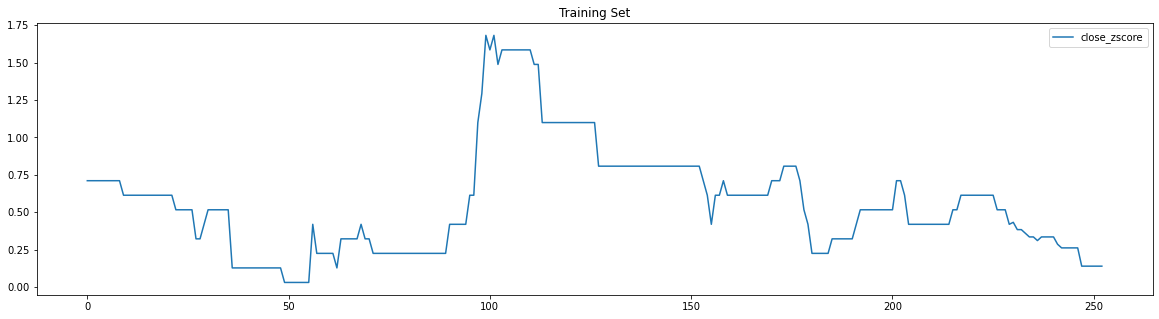

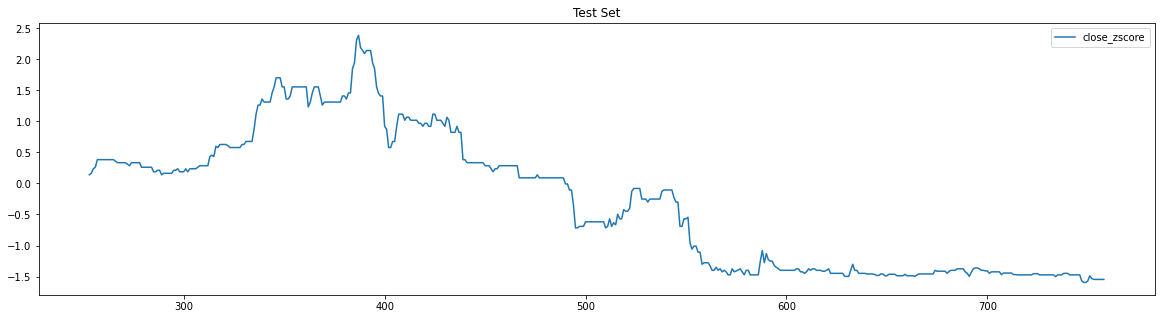

In [532]:
final_df_1.plot(y="close_zscore", figsize=(20,5),title="Original Dataframe")
train.plot(y="close_zscore", figsize=(20,5),title="Training Set")
test.plot(y="close_zscore", figsize=(20,5),title="Test Set");

In [533]:
# function to evaulate performance of the regressor. 
from sklearn.metrics import *
def evaulation(model, y_pred, y_true):
    
    '''
    Input:- model = string (Name of the regressor)
    y_pred= model prediction
    y_true = actual labels. 
    
    Output:
    Dataframe with evaulation matrix. 
    
    '''
    
    # create data output frame for the evaluation. 
    data = [explained_variance_score(y_true,y_pred), 
            max_error(y_true,y_pred),
            mean_squared_error(y_true,y_pred),
            mean_absolute_error(y_true,y_pred),
            r2_score(y_true,y_pred, multioutput='uniform_average'),
            median_absolute_error(y_true,y_pred)           
            ]
    row_index = ['Exp_Var_Score', 'Max_Error','MSE','MAE','R2_Score', 'Median_Abs_Error']
    
    df = pd.DataFrame(data, columns= [model], index= row_index)
    
    return df

In [534]:
X = train[['date_log', 'datetime_std', 'close_scale']]
Y = train['close_zscore'].values

In [535]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [536]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict the test data
y_pred_lr_new = lr.predict(X_test)

#evaulation of the lr   
print('Intercept:', lr.intercept_)
print('Coefficients:', lr.coef_)

Intercept: -0.5280096596053017
Coefficients: [2.09177824e+03 5.96551614e-01 9.11314477e-01]


In [537]:
# Linear regressor evaulation parameters
df_linear = evaulation('linear', y_pred_lr_new, y_test)
df_linear

,linear
Exp_Var_Score,0.199714
Max_Error,0.512670
MSE,0.089868
MAE,0.268528
R2_Score,-3.049442
Median_Abs_Error,0.248476


Use data for 2019 as a test set and evaluate the test set error for this set. Also, use data for 2020 as a test set and evaluate the test set error for this set. Compare these errors.

In [538]:
# predict 2019-2020
x = test[['date_log', 'datetime_std', 'close_scale']]
y = test['close_zscore'].values

In [539]:
new_preds = lr.predict(x)

In [540]:
# Linear regressor evaulation parameters
df_linear = evaulation('linear', new_preds, y)
df_linear

,linear
Exp_Var_Score,-0.165355
Max_Error,2.700333
MSE,2.791275
MAE,1.401190
R2_Score,-1.337786
Median_Abs_Error,1.265786


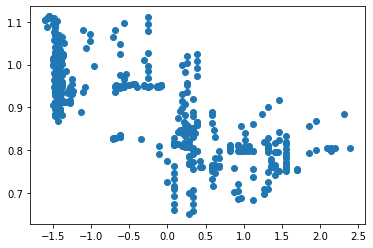

In [541]:
plt.scatter(y, new_preds);

Provide plots of 𝑔(𝑡), 𝑔̂(𝑡), and the residual. Present the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram. (30 marks)

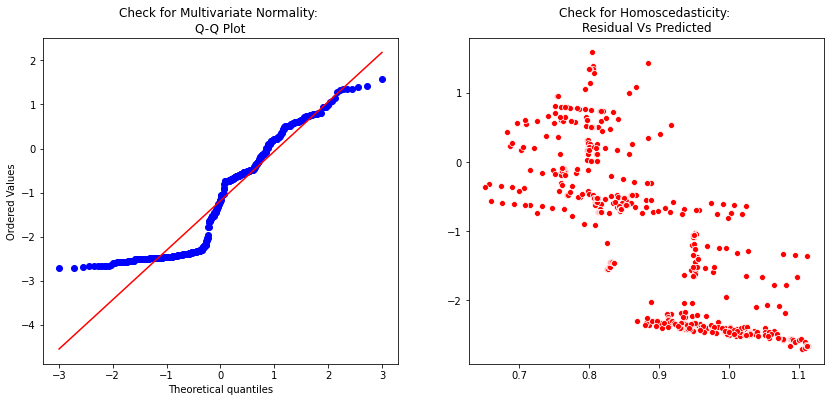

In [542]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y - new_preds),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y - new_preds), x= new_preds, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Answer : based on suggestions from questions, I trained my linear regression model using data from 2018, then made predictions for the next 2 years (2019 & 2020). As seen in the residual visualization above, my model can predict 80 % accurately.

4. Adaptive predictors. For each given value of the “frame width”, Δ=5, 10, 30, create and test the
following adaptive predictor. For every T> Δ create the training set with Δ input vectors
(𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡)) (𝑡 = 𝑇 − Δ, … , 𝑇-1) and the corresponding outputs 𝑔(𝑡 + 1).
In more detail, the input vectors 𝒙𝑖
 and the output values 𝑦𝑖
 for a given T are
𝒙1 = (𝑔(𝑇 − Δ), 𝑑1
(𝑇 − Δ), 𝑑2
(𝑇 − Δ), 𝑑3
(𝑇 − Δ)), 𝑦1 = 𝑔(𝑇 − Δ + 1)
………..
𝒙𝑖 = (𝑔(𝑇 − Δ + 𝑖 − 1), 𝑑1
(𝑇 − Δ + 𝑖 − 1), 𝑑2
(𝑇 − Δ + 𝑖 − 1), 𝑑3
(𝑇 − Δ + 𝑖 − 1)),
𝑦𝑖 = 𝑔(𝑇 − Δ + 𝑖)
Where i=1,2,…, Δ.
Find the linear regression (1) for each T> Δ. Test this linear regression for the next time value, t=T+1.
In more detail, for each T there is one test example with the input vector 𝒙𝑡𝑒𝑠𝑡 and output value 𝑦𝑡𝑒𝑠𝑡:
𝒙𝑡𝑒𝑠𝑡 = (𝑔(𝑇), 𝑑1
(𝑇), 𝑑2
(𝑇), 𝑑3
(𝑇)), 𝑦𝑡𝑒𝑠𝑡 = 𝑔(𝑇 + 1)
Please pay attention that this example does not belong to a training set for this value of T.
 Find the residuals at these test time moments. Plot these residuals and the values 𝑔(𝑡), 𝑔̂(𝑡). Present
the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram (t=T+1). Calculate the mean square error. Compare to the previous
task. Comment. (30 marks) 

In [543]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

In [544]:
# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

In [545]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,-0.528010,-0.528010
1,theta_1,date_log,2091.778236,2091.778236
2,theta_2,datetime_std,0.596552,0.596552
3,theta_3,close_scale,0.911314,0.911314


In [546]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  0.08986800911141855
R square obtain for normal equation method is : -3.0494415293302755


In [547]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse_sk)
print('R square obtain for scikit learn library is :',R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  0.0898680091114125
R square obtain for scikit learn library is : -3.049441529330003


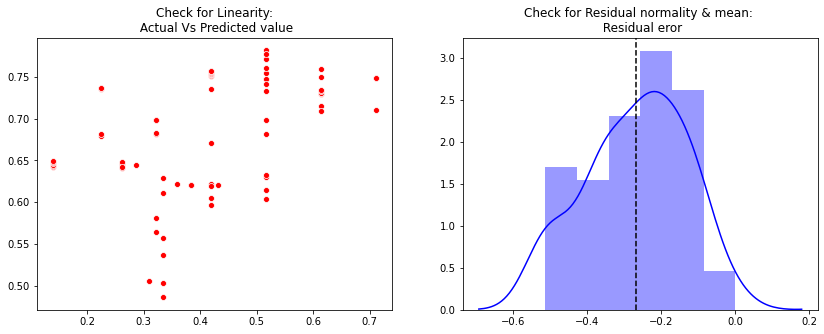

In [548]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

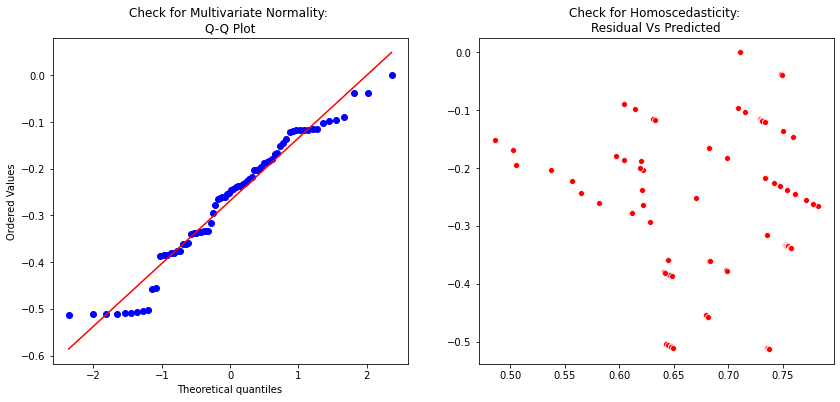

In [549]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Conclusion, based on the comparison of the residual visualization results on task 3 and 4, the visualization in task 4 as prediction set is better than in training visualisation

# Bakkavor Group plc Dataset

1. Data evaluation and elementary preprocessing. Analyse completeness of data. Are there missed
data (besides weekends)? How many missed data points are in your time series? Are the dates of
missed values the same for all your time series? What may be the reasons for missing? How can you
handle the missed values in your data (explain at least three approaches)? Use the simple rule: fill in a
missed value by the closest in time past existing value. Plot the results. Normalise to the z-score (zero
mean and unit standard deviation). Plot the results. (15 marks) 

In [550]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    759 non-null    object 
 1   Close   759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [551]:
df3.describe()

,Close
count,759.000000
mean,128.974374
std,44.190676
min,48.500000
25%,82.500000
50%,129.000000
75%,167.399994
max,212.500000


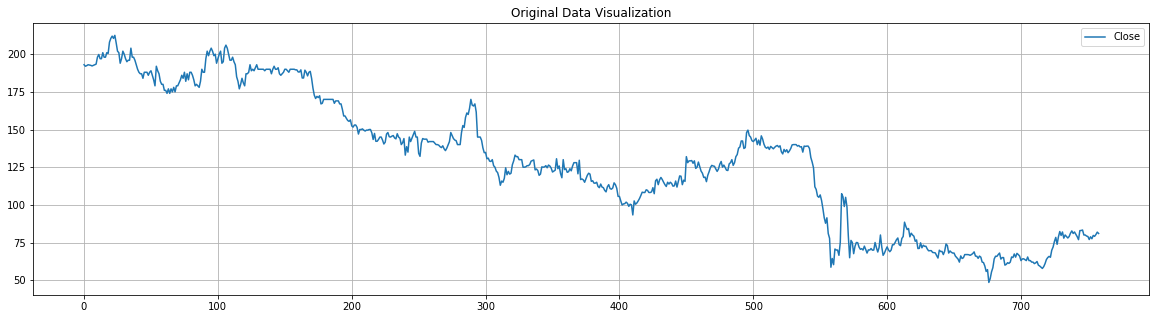

In [552]:
df3.plot(figsize=(20,5), grid=True, title="Original Data Visualization");

Are there missed data (besides weekends)?
How many missed data points are in your time series?

In [553]:
pd.date_range(start = '02-01-2018', end = '30-12-2020' ).difference(df1.index).isnull().sum()

0

Answer : No

Normalise to the z-score (zero mean and unit standard deviation). Plot the results.

In [556]:
df1_norm = z_score(df3) 

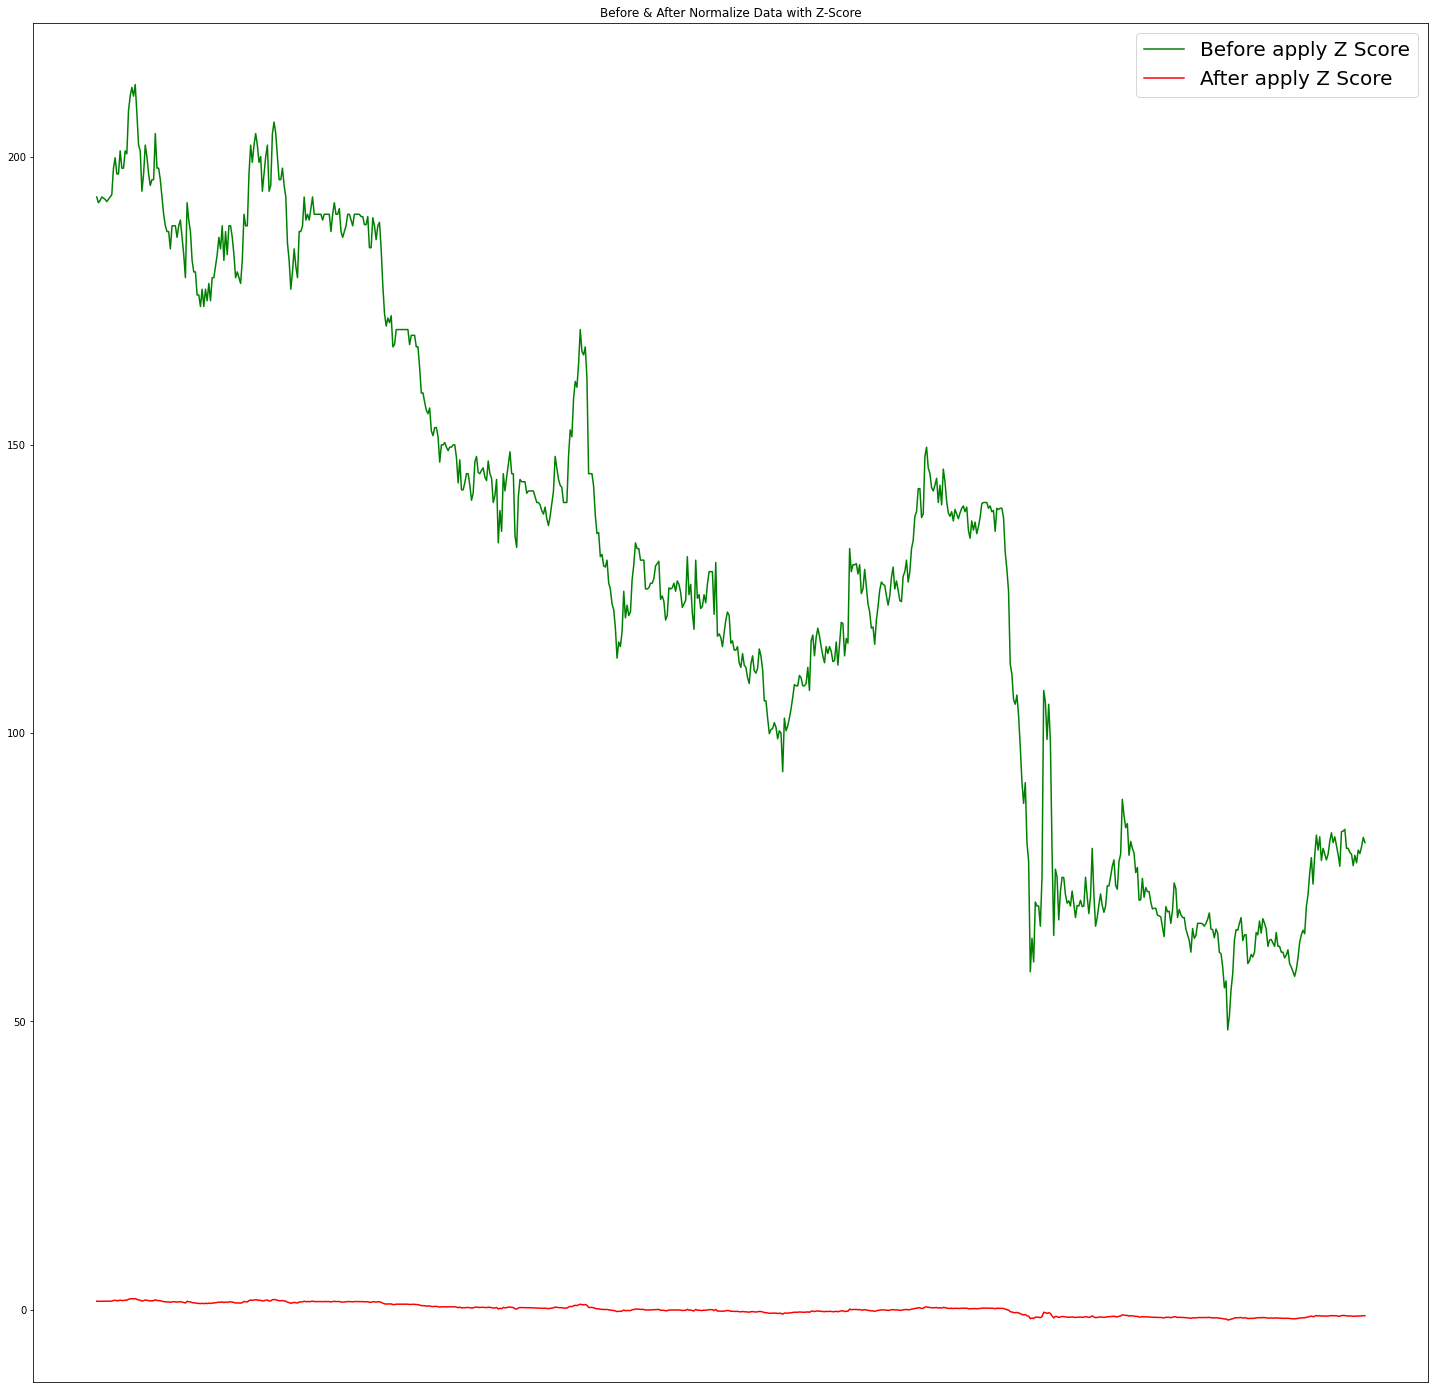

In [557]:
plt.figure(figsize=(25,25))
plt.plot(df3.Date, df3.Close, color="green", label="Before apply Z Score")
plt.plot(df3.Date, df1_norm.Close, color="red", label="After apply Z Score")
plt.legend(prop={'size': 20})
plt.title("Before & After Normalize Data with Z-Score")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False); # labels along the bottom edge are off

2. Segmentation. Prepare the bottom-up piecewise linear segmentation for the transformed and
normalised log-return time series. Use the following mean square errors tolerance levels: 1%, 5%, 10%
(the thresholds of the mean square errors). Plot the results. Are the segments similar for different time
series you analysed? (25 marks) 

 Prepare the bottom-up piecewise linear segmentation

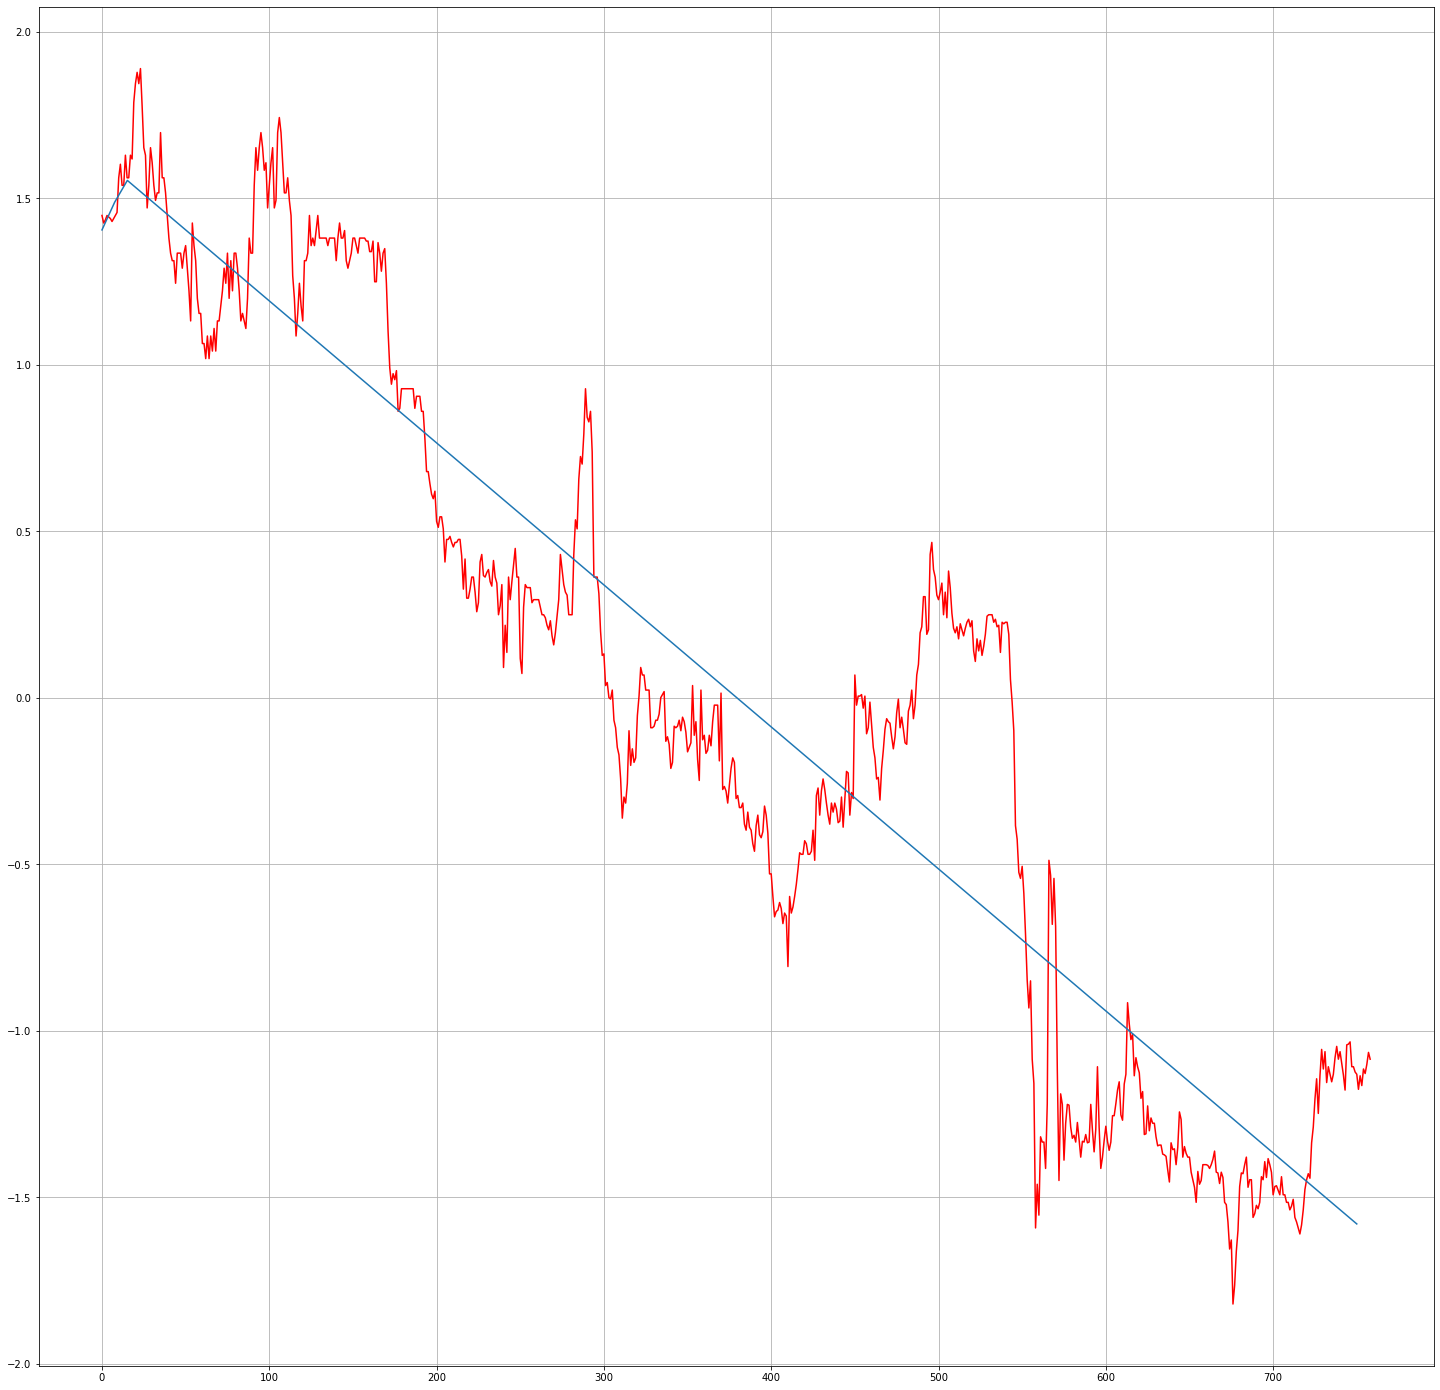

In [560]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

x = [x for x in range(len(df3.Date))]
y = df1_norm.Close

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 750, 100)
plt.figure(figsize=(25,25))
plt.plot(x, y, color="red")
plt.grid(True)
plt.plot(xd, piecewise_linear(xd, *p));

for the transformed and normalised log-return time series.

In [561]:
df1_norm.Date = [np.float32(to_integer(x)) for x in df1_norm.Date]

In [562]:
df1_norm.head(2)

,Date,Close
0,20180102.0,1.448849
1,20180104.0,1.426220


In [564]:
x = np.array([x for x in range(len(df1_norm.Date.astype(int)))])
y = np.array(df1_norm.Close)

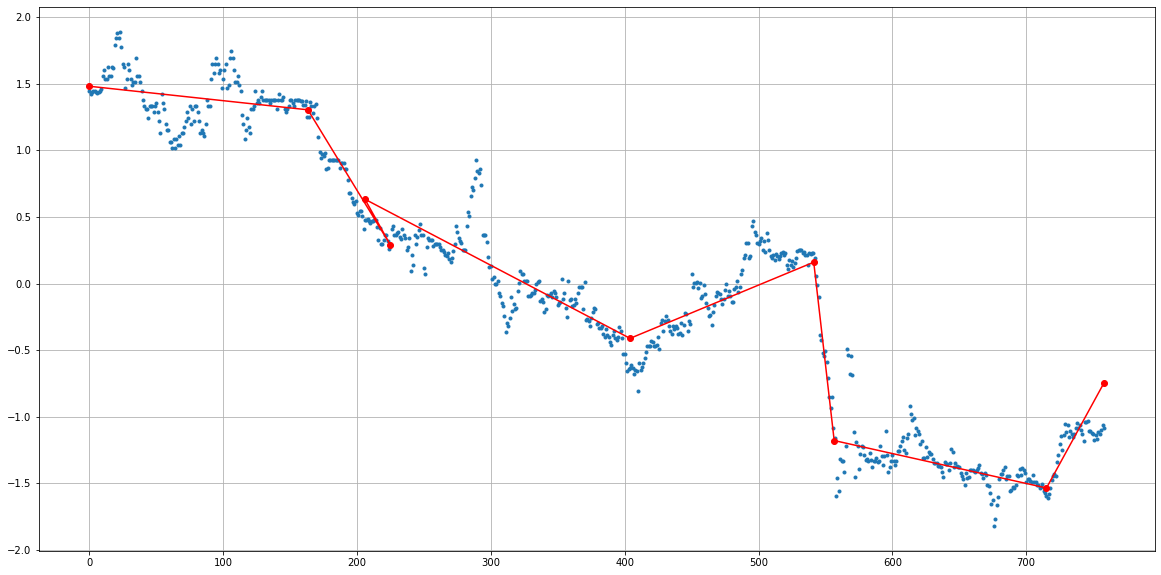

In [565]:
px, py = segments_fit(x, y, 8)
plt.figure(figsize=(20,10))
plt.grid(True)
pl.plot(x, y, ".")
pl.plot(px, py, "-or");

In [566]:
df1.Date = pd.to_datetime(df3.Date)

In [576]:
timeseries = df1.Date

In [577]:
X = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())

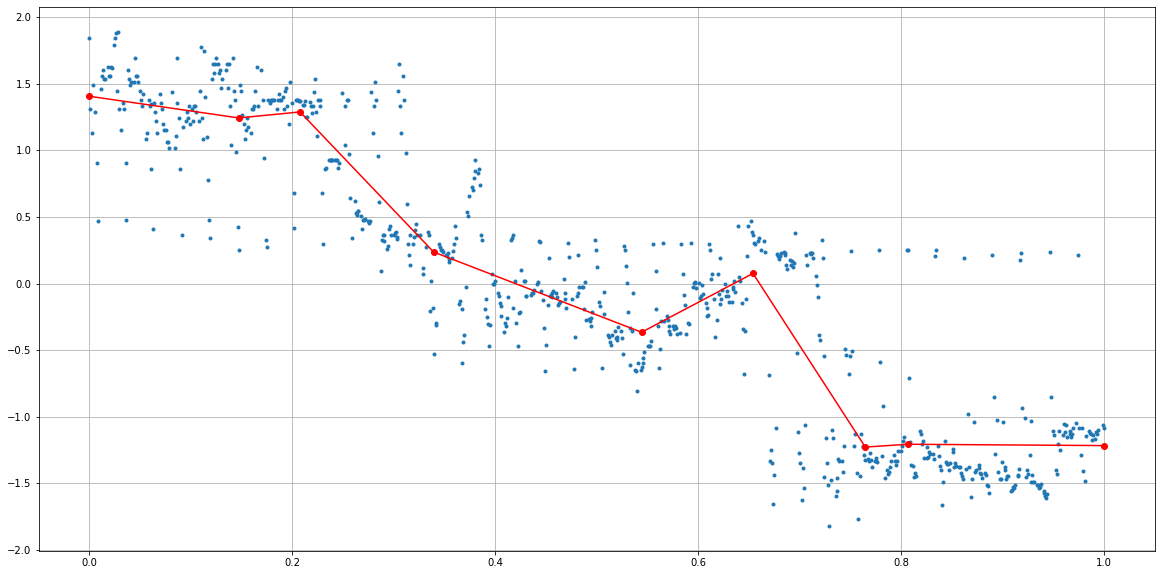

In [578]:
px, py = segments_fit(X, y, 8)
plt.figure(figsize=(20,10))
plt.grid(True)
pl.plot(X, y, ".")
pl.plot(px, py, "-or");

In [579]:
timeseries = df1_norm.Date

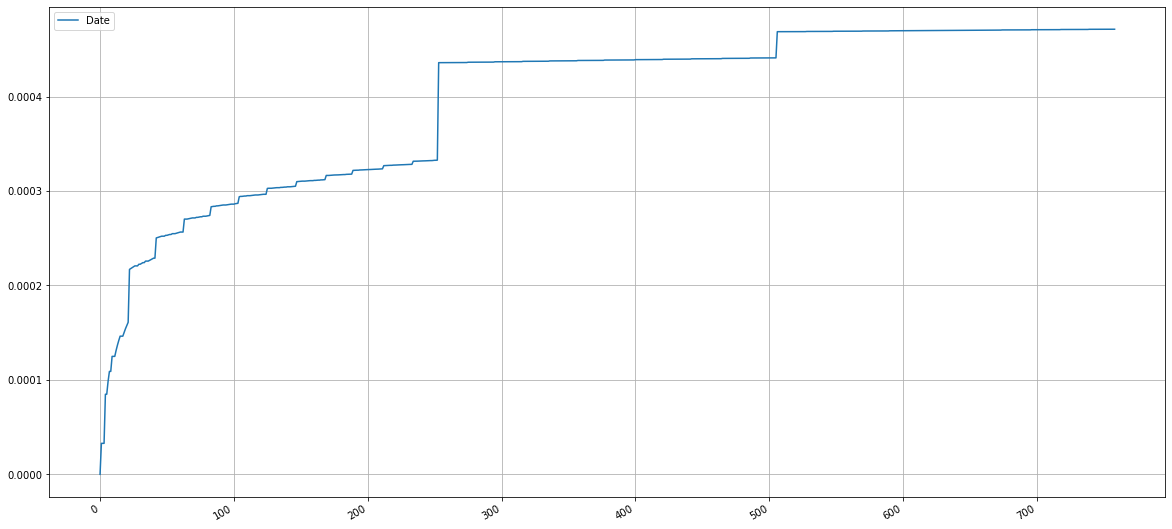

In [580]:
log = pd.DataFrame(np.log(timeseries-timeseries.min())/(timeseries.max()-timeseries.min()))

# Differencing the log values twice. 
log_diff = log.replace({np.nan:0,-np.inf:0})
log_diff.plot(subplots=True, figsize=(20,10), grid=True);

se the following mean square errors tolerance levels: 1%, 5%, 10% (the thresholds of the mean square errors).

In [581]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag= "BIC")
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num of Observations Used For ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [582]:
ad_test(log_diff["Date"])

1. ADF :  -6.909175193165739
2. P-Value :  1.224913506977124e-09
3. Num Of Lags :  0
4. Num of Observations Used For ADF Regression and Critical Values Calculation :  758
5. Critical Values : 
	 1% :  -3.439006442437876
	 5% :  -2.865360521688131
	 10% :  -2.5688044403756587


In [583]:
final_df_1 = pd.DataFrame({"date_log":log_diff["Date"],
                           "close_zscore":y})

In [584]:
final_df_1

,date_log,close_zscore
0,0.000000,1.448849
1,0.000033,1.426220
2,0.000033,1.435272
3,0.000033,1.448849
4,0.000085,1.444323
...,...,...
754,0.000471,-1.115040
755,0.000471,-1.128618
756,0.000471,-1.101462
757,0.000471,-1.065256


In [585]:
n_obs = 100
train, test = final_df_1[:-n_obs], final_df_1[-n_obs:]

In [586]:
# Fitting the VAR model
from statsmodels.tsa.api import VAR

model = VAR(final_df_1)
results = model.fit(maxlags = 25, ic = 'aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, May, 2021
Time:                     22:15:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -29.3980
Nobs:                     758.000    HQIC:                  -29.4206
Log likelihood:           9010.64    FPE:                1.64693e-13
AIC:                     -29.4347    Det(Omega_mle):     1.63397e-13
--------------------------------------------------------------------
Results for equation date_log
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.000010         0.000001            7.215           0.000
L1.date_log             0.975694         0.003558          274.241           0.000
L1.close_zscore        -0.000001         0.000000

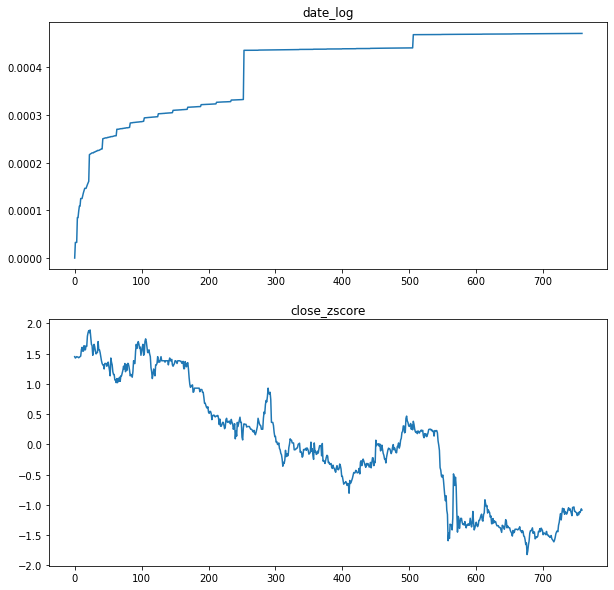

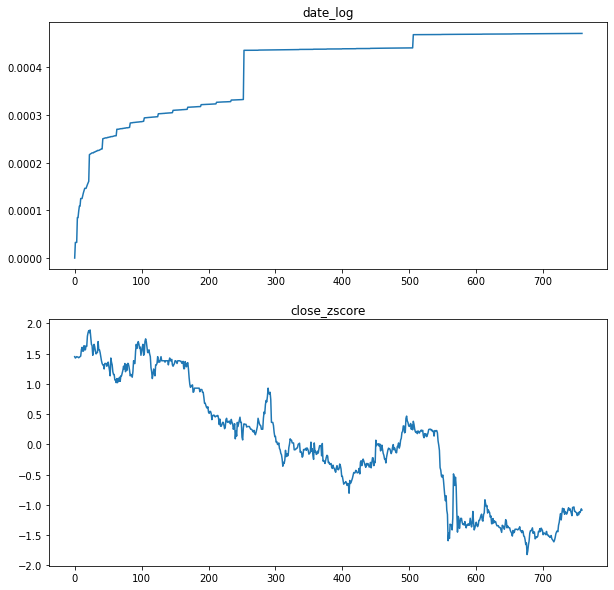

In [587]:
results.plot()

In [588]:
final_df_1["datetime_std"] =  X

In [592]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
close_scaled = scale.fit_transform(df3.Close.values.reshape(-1,1))

In [593]:
final_df_1["close_scale"] = close_scaled

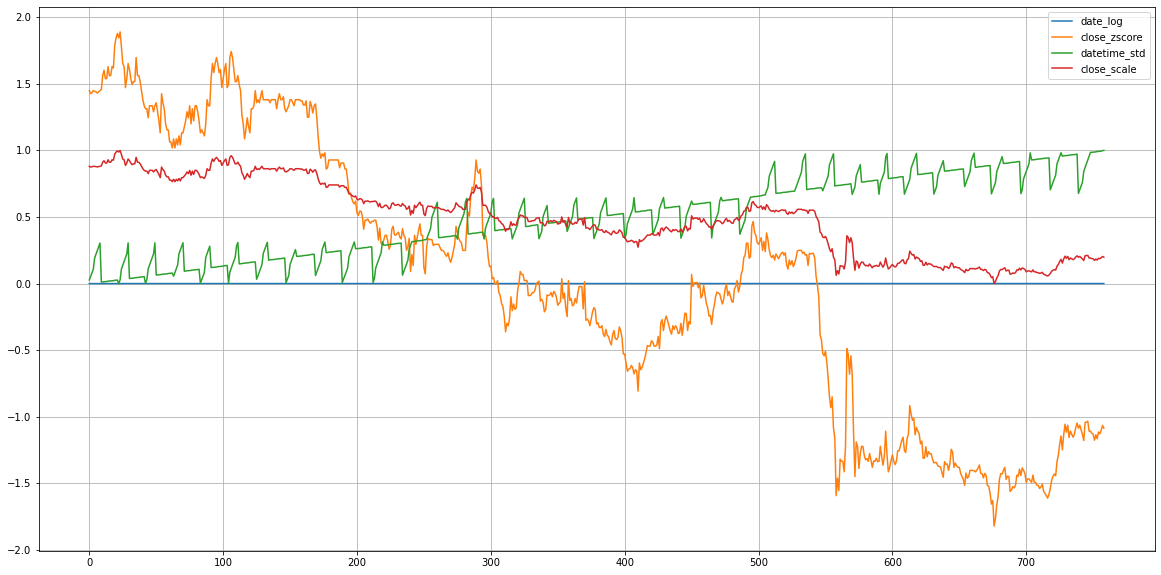

In [594]:
final_df_1.plot(figsize=(20,10), grid=True);

 Are the segments similar for different time series you analysed?

Yes

3. Prediction. Chose one of the transformed and normalised time series as a target 𝑔(𝑡) and other 3 as
supporting data 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡), where 𝑡 = 1, … , 𝑇. Provide scatter diagrams of (g(t),g(t+1)).
Evaluate the error of the “next-day forecast”, 𝑔̂(𝑡 + 1) = 𝑔(𝑡).
Use data for 2018 as the training set and find the predictor of 𝑔(𝑡 + 1) (the next day value) as a
linear function Ψ of 𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡):
𝑔̂(𝑡 + 1) = Ψ(𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡)) (1)
(linear regression). Evaluate the training set error. Use data for 2019 as a test set and evaluate the test
set error for this set. Also, use data for 2020 as a test set and evaluate the test set error for this set.
Compare these errors. Compare these errors to the errors of the “next-day forecast”. Comment.
Provide plots of 𝑔(𝑡), 𝑔̂(𝑡), and the residual. Present the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram. (30 marks) 

In [595]:
final_df_1["Date"] = df1_norm.Date.astype(int).astype(str).apply(lambda x: x[0:4])

In [596]:
final_df_1.head()

,date_log,close_zscore,datetime_std,close_scale,Date
0,0.000000,1.448849,0.027447,0.881098,2018
1,0.000033,1.426220,0.053065,0.875000,2018
2,0.000033,1.435272,0.081427,0.877439,2018
3,0.000033,1.448849,0.108875,0.881098,2018
4,0.000085,1.444323,0.193047,0.879878,2018


Use data for 2018 as the training set and find the predictor of 𝑔(𝑡 + 1) (the next day value) as a linear function Ψ of 𝑔(𝑡), 𝑑1 (𝑡), 𝑑2 (𝑡), 𝑑3 (𝑡): 𝑔̂(𝑡 + 1) = Ψ(𝑔(𝑡), 𝑑1 (𝑡), 𝑑2 (𝑡), 𝑑3 (𝑡)) (1) (linear regression).

In [597]:
train = final_df_1.loc[final_df_1["Date"] == "2018"]
test  = final_df_1.loc[final_df_1["Date"] != "2018"] 

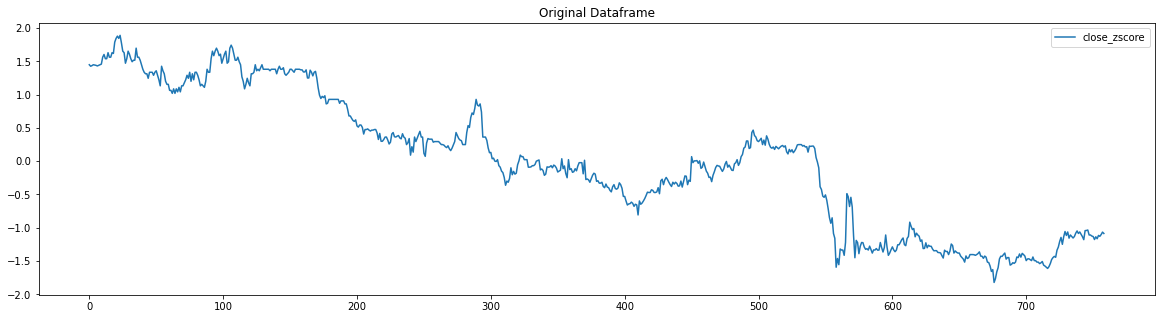

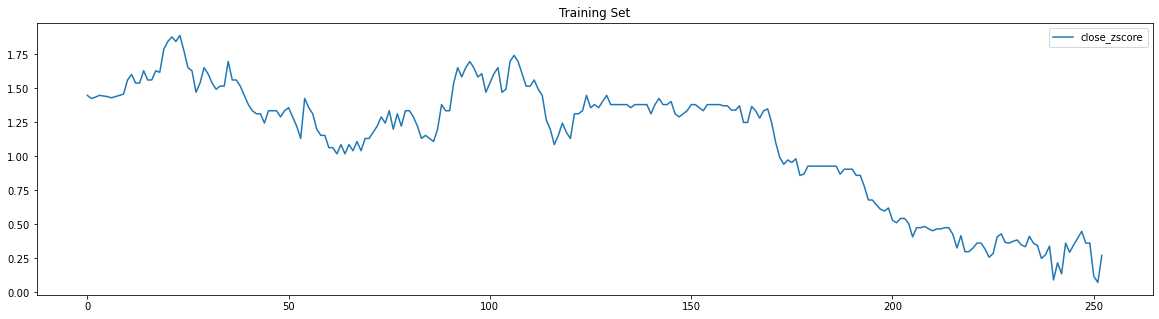

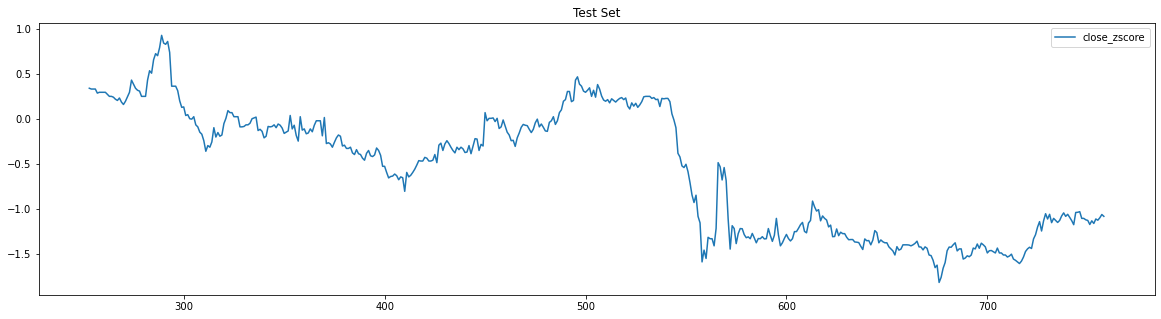

In [598]:
final_df_1.plot(y="close_zscore", figsize=(20,5),title="Original Dataframe")
train.plot(y="close_zscore", figsize=(20,5),title="Training Set")
test.plot(y="close_zscore", figsize=(20,5),title="Test Set");

In [599]:
# function to evaulate performance of the regressor. 
from sklearn.metrics import *
def evaulation(model, y_pred, y_true):
    
    '''
    Input:- model = string (Name of the regressor)
    y_pred= model prediction
    y_true = actual labels. 
    
    Output:
    Dataframe with evaulation matrix. 
    
    '''
    
    # create data output frame for the evaluation. 
    data = [explained_variance_score(y_true,y_pred), 
            max_error(y_true,y_pred),
            mean_squared_error(y_true,y_pred),
            mean_absolute_error(y_true,y_pred),
            r2_score(y_true,y_pred, multioutput='uniform_average'),
            median_absolute_error(y_true,y_pred)           
            ]
    row_index = ['Exp_Var_Score', 'Max_Error','MSE','MAE','R2_Score', 'Median_Abs_Error']
    
    df = pd.DataFrame(data, columns= [model], index= row_index)
    
    return df

In [600]:
X = train[['date_log', 'datetime_std', 'close_scale']]
Y = train['close_zscore'].values

In [601]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [602]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict the test data
y_pred_lr_new = lr.predict(X_test)

#evaulation of the lr   
print('Intercept:', lr.intercept_)
print('Coefficients:', lr.coef_)

Intercept: -1.8210713718983005
Coefficients: [-1.16501360e-12  0.00000000e+00  3.71119015e+00]


In [603]:
# Linear regressor evaulation parameters
df_linear = evaulation('linear', y_pred_lr_new, y_test)
df_linear

,linear
Exp_Var_Score,1.000000e+00
Max_Error,1.582068e-15
MSE,9.357866e-31
MAE,8.850742e-16
R2_Score,1.000000e+00
Median_Abs_Error,9.992007e-16


Use data for 2019 as a test set and evaluate the test set error for this set. Also, use data for 2020 as a test set and evaluate the test set error for this set. Compare these errors.

In [604]:
# predict 2019-2020
x = test[['date_log', 'datetime_std', 'close_scale']]
y = test['close_zscore'].values

In [605]:
new_preds = lr.predict(x)

In [606]:
# Linear regressor evaulation parameters
df_linear = evaulation('linear', new_preds, y)
df_linear

,linear
Exp_Var_Score,1.000000e+00
Max_Error,3.108624e-15
MSE,4.191979e-30
MAE,1.923280e-15
R2_Score,1.000000e+00
Median_Abs_Error,1.706968e-15


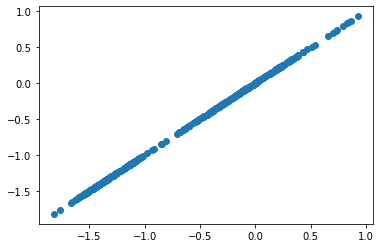

In [607]:
plt.scatter(y, new_preds);

Provide plots of 𝑔(𝑡), 𝑔̂(𝑡), and the residual. Present the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram. (30 marks)

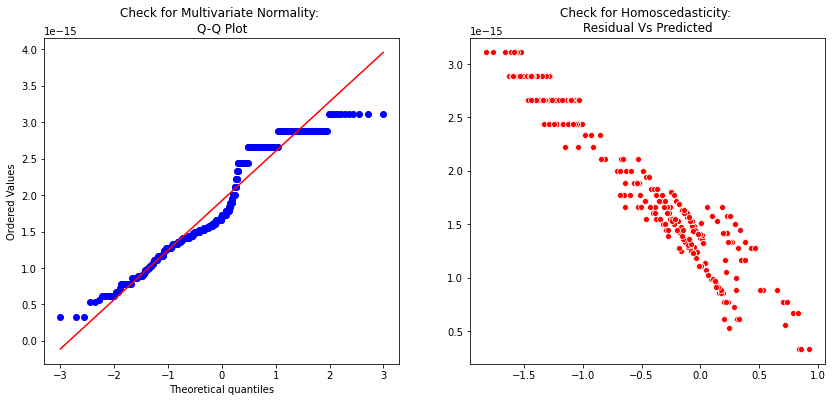

In [608]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y - new_preds),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y - new_preds), x= new_preds, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Answer : based on suggestions from questions, I trained my linear regression model using data from 2018, then made predictions for the next 2 years (2019 & 2020). As seen in the residual visualization above, my model can predict accurately.

4. Adaptive predictors. For each given value of the “frame width”, Δ=5, 10, 30, create and test the
following adaptive predictor. For every T> Δ create the training set with Δ input vectors
(𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡)) (𝑡 = 𝑇 − Δ, … , 𝑇-1) and the corresponding outputs 𝑔(𝑡 + 1).
In more detail, the input vectors 𝒙𝑖
 and the output values 𝑦𝑖
 for a given T are
𝒙1 = (𝑔(𝑇 − Δ), 𝑑1
(𝑇 − Δ), 𝑑2
(𝑇 − Δ), 𝑑3
(𝑇 − Δ)), 𝑦1 = 𝑔(𝑇 − Δ + 1)
………..
𝒙𝑖 = (𝑔(𝑇 − Δ + 𝑖 − 1), 𝑑1
(𝑇 − Δ + 𝑖 − 1), 𝑑2
(𝑇 − Δ + 𝑖 − 1), 𝑑3
(𝑇 − Δ + 𝑖 − 1)),
𝑦𝑖 = 𝑔(𝑇 − Δ + 𝑖)
Where i=1,2,…, Δ.
Find the linear regression (1) for each T> Δ. Test this linear regression for the next time value, t=T+1.
In more detail, for each T there is one test example with the input vector 𝒙𝑡𝑒𝑠𝑡 and output value 𝑦𝑡𝑒𝑠𝑡:
𝒙𝑡𝑒𝑠𝑡 = (𝑔(𝑇), 𝑑1
(𝑇), 𝑑2
(𝑇), 𝑑3
(𝑇)), 𝑦𝑡𝑒𝑠𝑡 = 𝑔(𝑇 + 1)
Please pay attention that this example does not belong to a training set for this value of T.
 Find the residuals at these test time moments. Plot these residuals and the values 𝑔(𝑡), 𝑔̂(𝑡). Present
the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram (t=T+1). Calculate the mean square error. Compare to the previous
task. Comment. (30 marks) 

In [609]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

In [610]:
# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

In [611]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,-1.821071e+00,-1.821071e+00
1,theta_1,date_log,-3.201421e-10,-1.165014e-12
2,theta_2,datetime_std,-5.329071e-14,0.000000e+00
3,theta_3,close_scale,3.711190e+00,3.711190e+00


In [612]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  1.4131161124301062e-26
R square obtain for normal equation method is : 1.0


In [613]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse_sk)
print('R square obtain for scikit learn library is :',R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  9.35786552912627e-31
R square obtain for scikit learn library is : 1.0


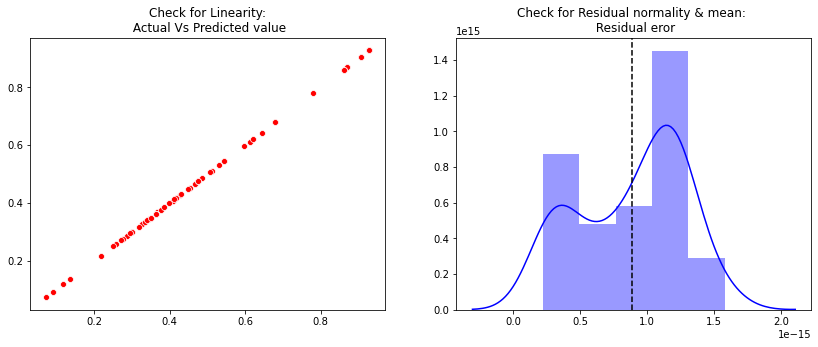

In [614]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

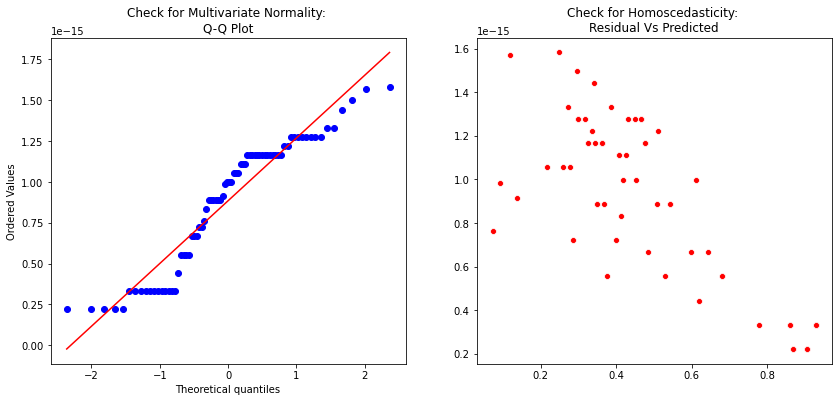

In [615]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Conclusion, based on the comparison of the residual visualization results on task 3 and 4, the visualization is the almost same, but we have some unordered variable as our prediction in task 4 visualisation 

# Concurrent Technologies PLC Dataset

1. Data evaluation and elementary preprocessing. Analyse completeness of data. Are there missed
data (besides weekends)? How many missed data points are in your time series? Are the dates of
missed values the same for all your time series? What may be the reasons for missing? How can you
handle the missed values in your data (explain at least three approaches)? Use the simple rule: fill in a
missed value by the closest in time past existing value. Plot the results. Normalise to the z-score (zero
mean and unit standard deviation). Plot the results. (15 marks) 

In [616]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    759 non-null    object 
 1   Close   759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [617]:
df4.describe()

,Close
count,759.000000
mean,83.198946
std,15.035839
min,62.000000
25%,73.500000
50%,78.000000
75%,92.500000
max,124.000000


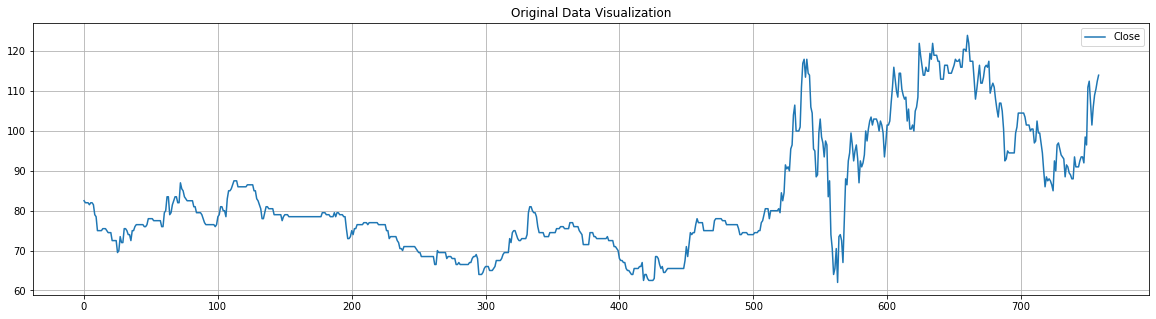

In [618]:
df4.plot(figsize=(20,5), grid=True, title="Original Data Visualization");

Are there missed data (besides weekends)?
How many missed data points are in your time series?

In [619]:
pd.date_range(start = '02-01-2018', end = '30-12-2020' ).difference(df1.index).isnull().sum()

0

Answer : No

Normalise to the z-score (zero mean and unit standard deviation). Plot the results.

In [620]:
df1_norm = z_score(df4) 

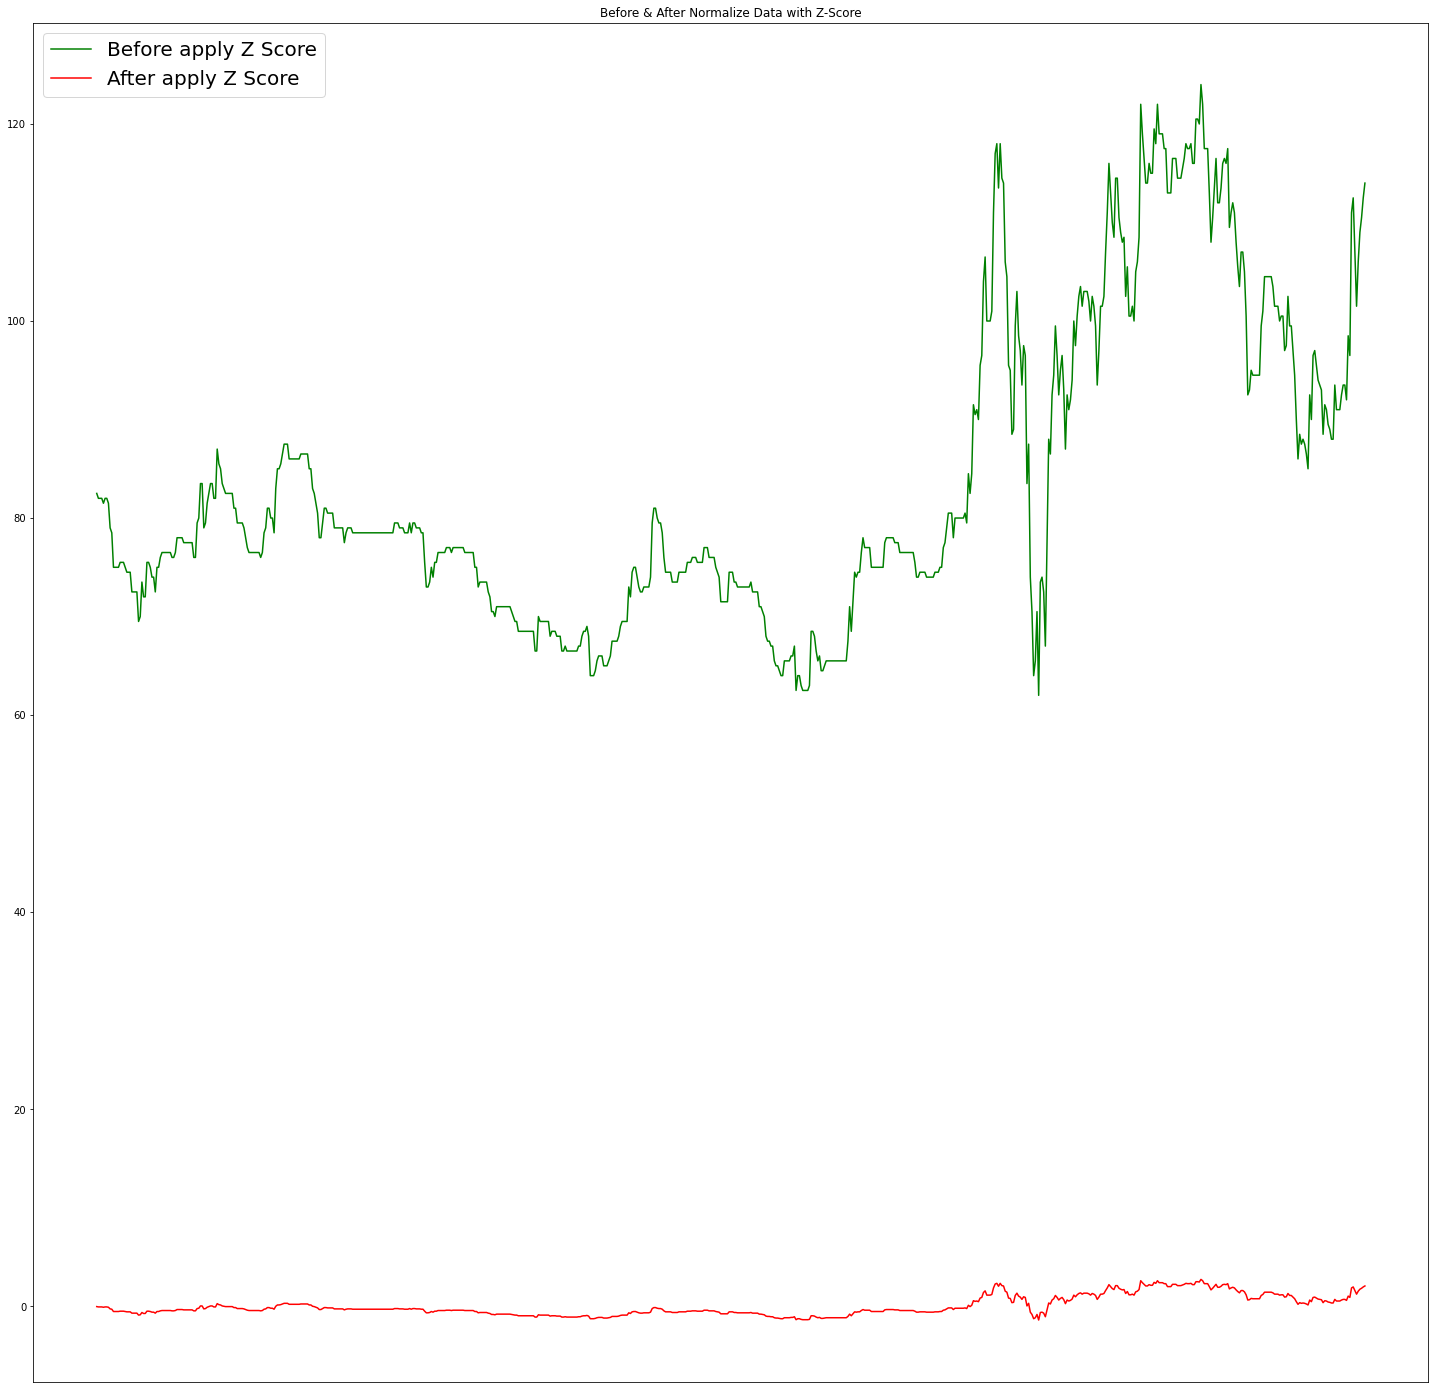

In [622]:
plt.figure(figsize=(25,25))
plt.plot(df4.Date, df4.Close, color="green", label="Before apply Z Score")
plt.plot(df4.Date, df1_norm.Close, color="red", label="After apply Z Score")
plt.legend(prop={'size': 20})
plt.title("Before & After Normalize Data with Z-Score")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False); # labels along the bottom edge are off

2. Segmentation. Prepare the bottom-up piecewise linear segmentation for the transformed and
normalised log-return time series. Use the following mean square errors tolerance levels: 1%, 5%, 10%
(the thresholds of the mean square errors). Plot the results. Are the segments similar for different time
series you analysed? (25 marks) 

 Prepare the bottom-up piecewise linear segmentation

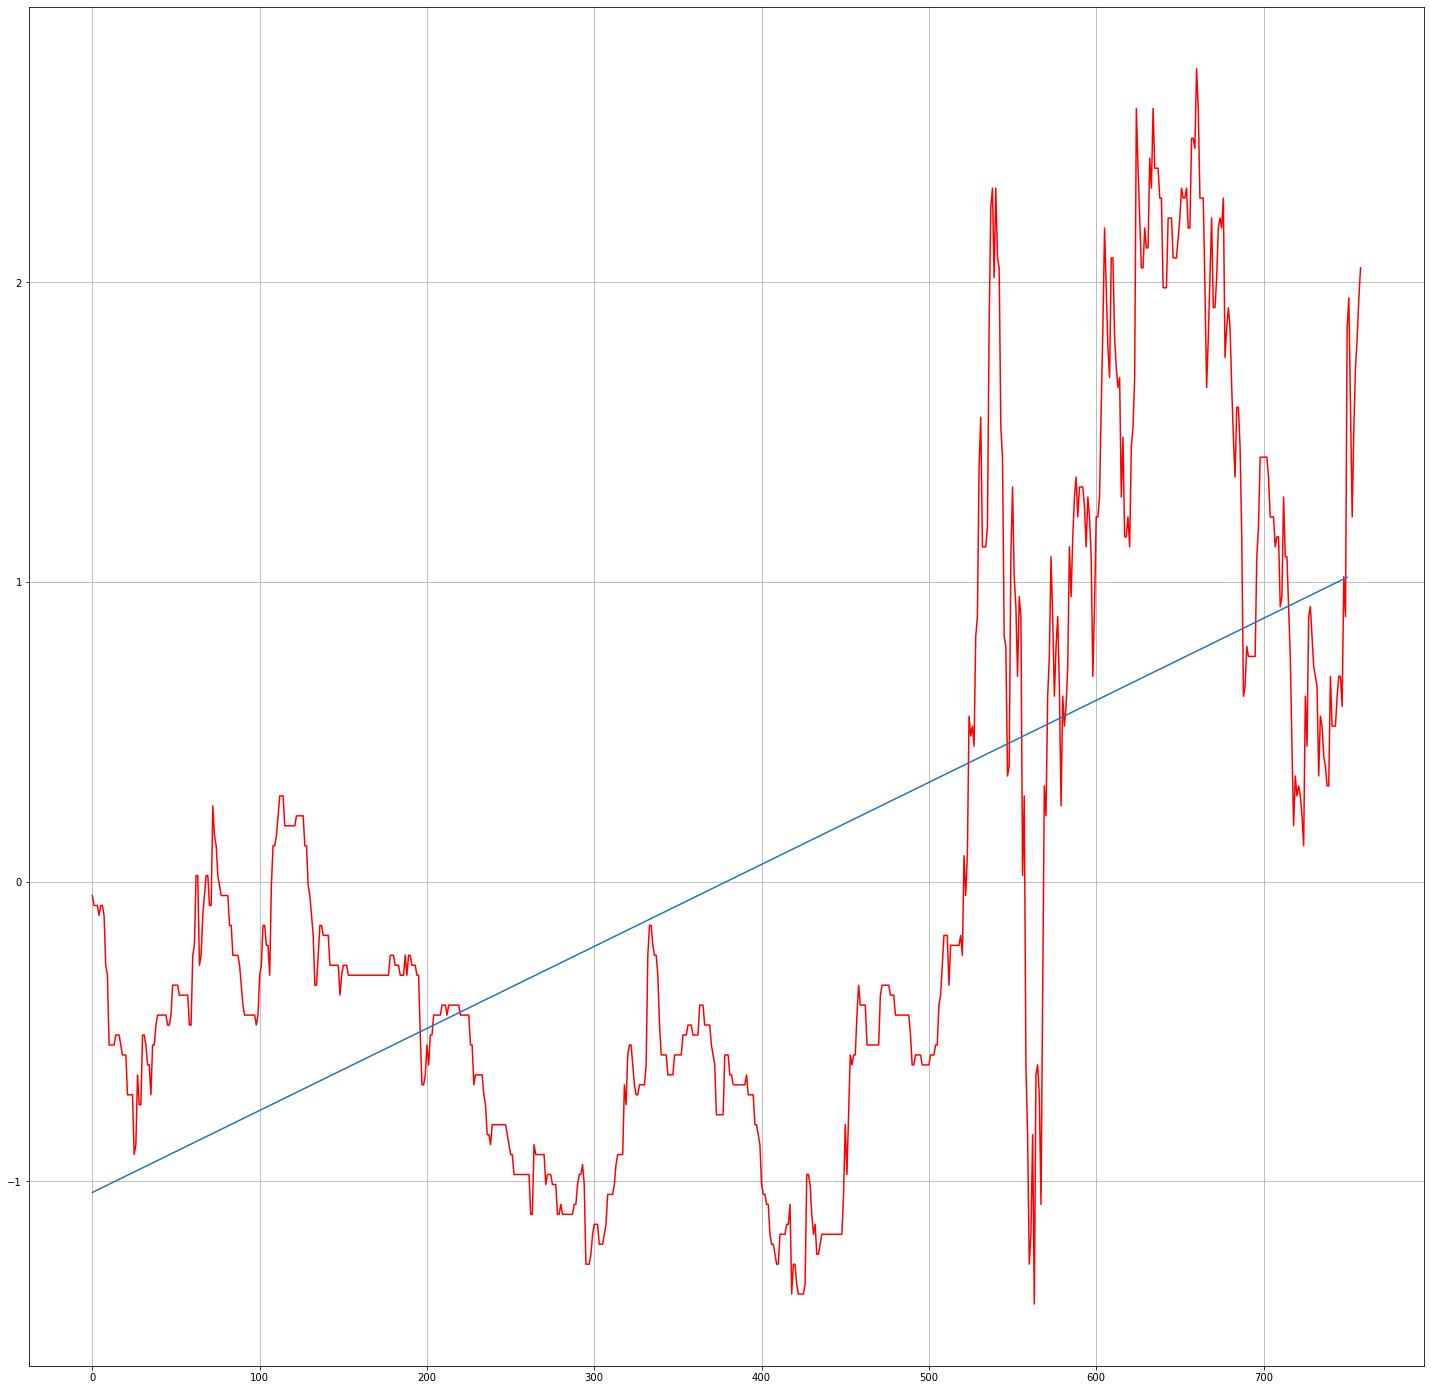

In [623]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

x = [x for x in range(len(df4.Date))]
y = df1_norm.Close

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 750, 100)
plt.figure(figsize=(25,25))
plt.plot(x, y, color="red")
plt.grid(True)
plt.plot(xd, piecewise_linear(xd, *p));

for the transformed and normalised log-return time series.

In [624]:
df1_norm.Date = [np.float32(to_integer(x)) for x in df1_norm.Date]

In [625]:
df1_norm.head(2)

,Date,Close
0,20180102.0,-0.046485
1,20180104.0,-0.079739


In [626]:
x = np.array([x for x in range(len(df1_norm.Date.astype(int)))])
y = np.array(df1_norm.Close)

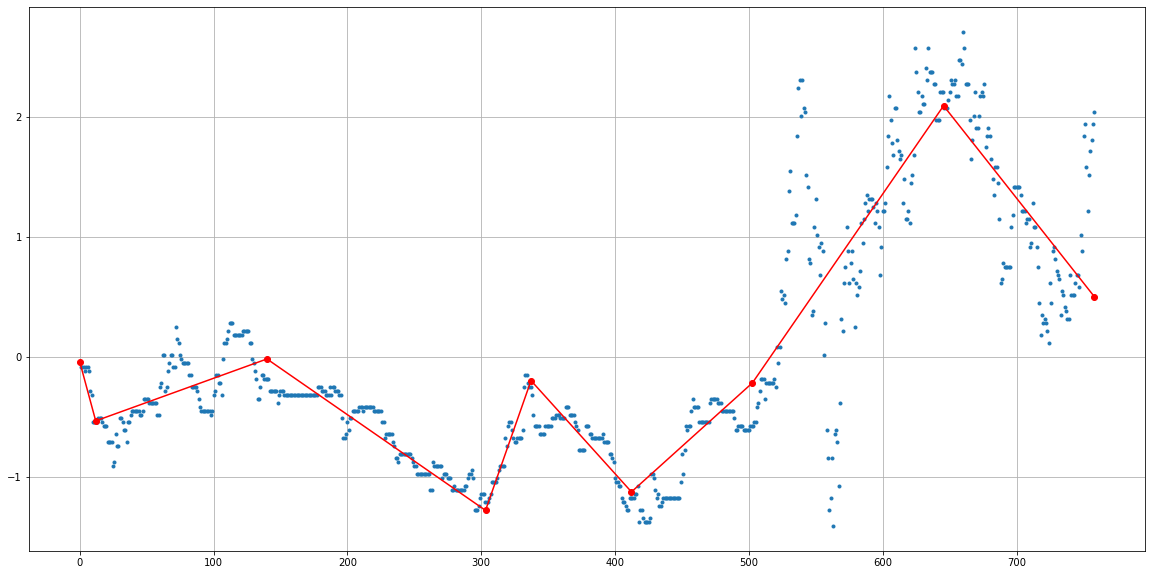

In [627]:
px, py = segments_fit(x, y, 8)
plt.figure(figsize=(20,10))
plt.grid(True)
pl.plot(x, y, ".")
pl.plot(px, py, "-or");

In [628]:
df1.Date = pd.to_datetime(df4.Date)

In [629]:
timeseries = df1.Date

In [630]:
X = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())

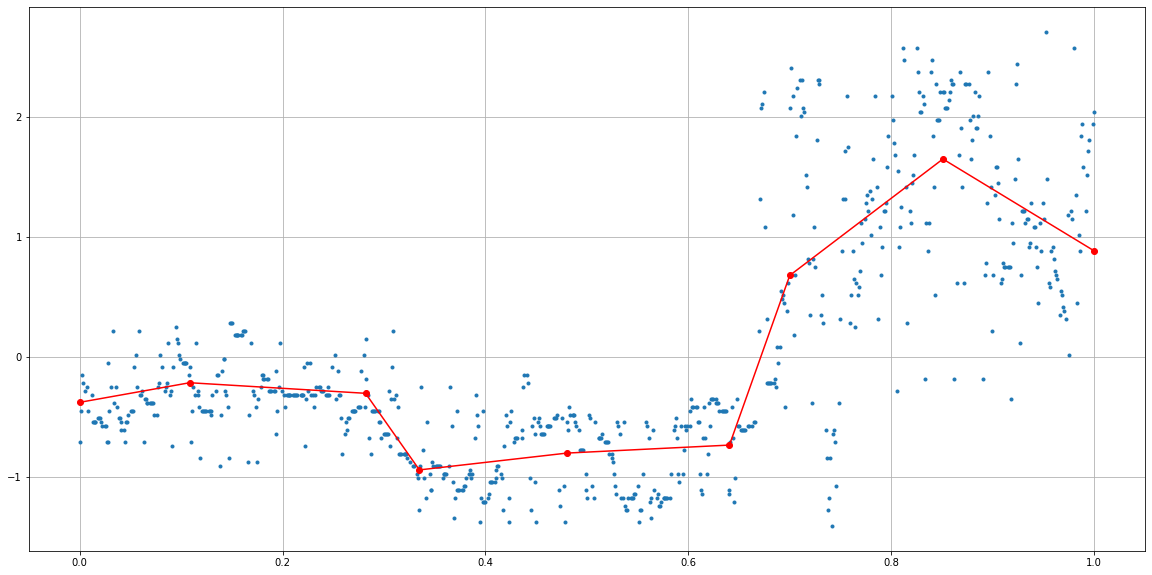

In [631]:
px, py = segments_fit(X, y, 8)
plt.figure(figsize=(20,10))
plt.grid(True)
pl.plot(X, y, ".")
pl.plot(px, py, "-or");

In [632]:
timeseries = df1_norm.Date

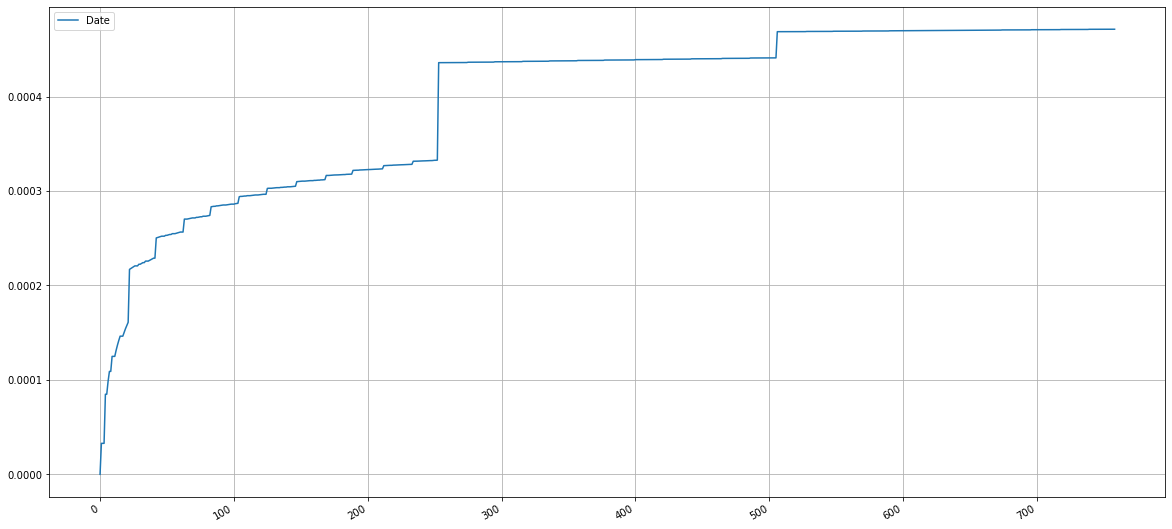

In [633]:
log = pd.DataFrame(np.log(timeseries-timeseries.min())/(timeseries.max()-timeseries.min()))

# Differencing the log values twice. 
log_diff = log.replace({np.nan:0,-np.inf:0})
log_diff.plot(subplots=True, figsize=(20,10), grid=True);

se the following mean square errors tolerance levels: 1%, 5%, 10% (the thresholds of the mean square errors).

In [634]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag= "BIC")
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num of Observations Used For ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [635]:
ad_test(log_diff["Date"])

1. ADF :  -6.909175193165739
2. P-Value :  1.224913506977124e-09
3. Num Of Lags :  0
4. Num of Observations Used For ADF Regression and Critical Values Calculation :  758
5. Critical Values : 
	 1% :  -3.439006442437876
	 5% :  -2.865360521688131
	 10% :  -2.5688044403756587


In [636]:
final_df_1 = pd.DataFrame({"date_log":log_diff["Date"],
                           "close_zscore":y})

In [637]:
final_df_1

,date_log,close_zscore
0,0.000000,-0.046485
1,0.000033,-0.079739
2,0.000033,-0.079739
3,0.000033,-0.079739
4,0.000085,-0.112993
...,...,...
754,0.000471,1.516447
755,0.000471,1.715970
756,0.000471,1.815732
757,0.000471,1.948747


In [638]:
n_obs = 100
train, test = final_df_1[:-n_obs], final_df_1[-n_obs:]

In [639]:
# Fitting the VAR model
from statsmodels.tsa.api import VAR

model = VAR(final_df_1)
results = model.fit(maxlags = 25, ic = 'aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, May, 2021
Time:                     22:21:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -28.1024
Nobs:                     758.000    HQIC:                  -28.1250
Log likelihood:           8519.60    FPE:                6.01657e-13
AIC:                     -28.1391    Det(Omega_mle):     5.96922e-13
--------------------------------------------------------------------
Results for equation date_log
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.000006         0.000001            7.326           0.000
L1.date_log             0.985857         0.002096          470.366           0.000
L1.close_zscore         0.000000         0.000000

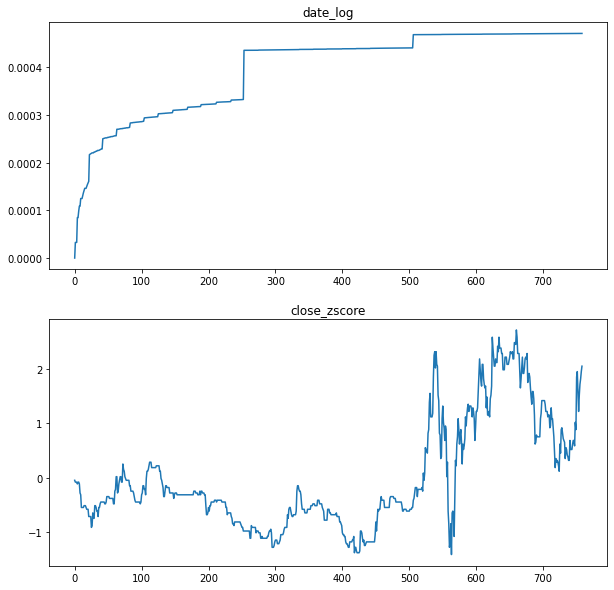

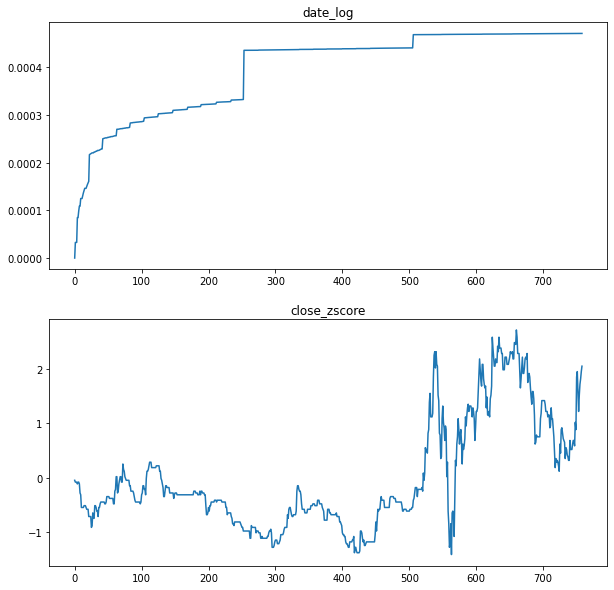

In [640]:
results.plot()

In [641]:
final_df_1["datetime_std"] =  X

In [642]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
close_scaled = scale.fit_transform(df4.Close.values.reshape(-1,1))

In [643]:
final_df_1["close_scale"] = close_scaled

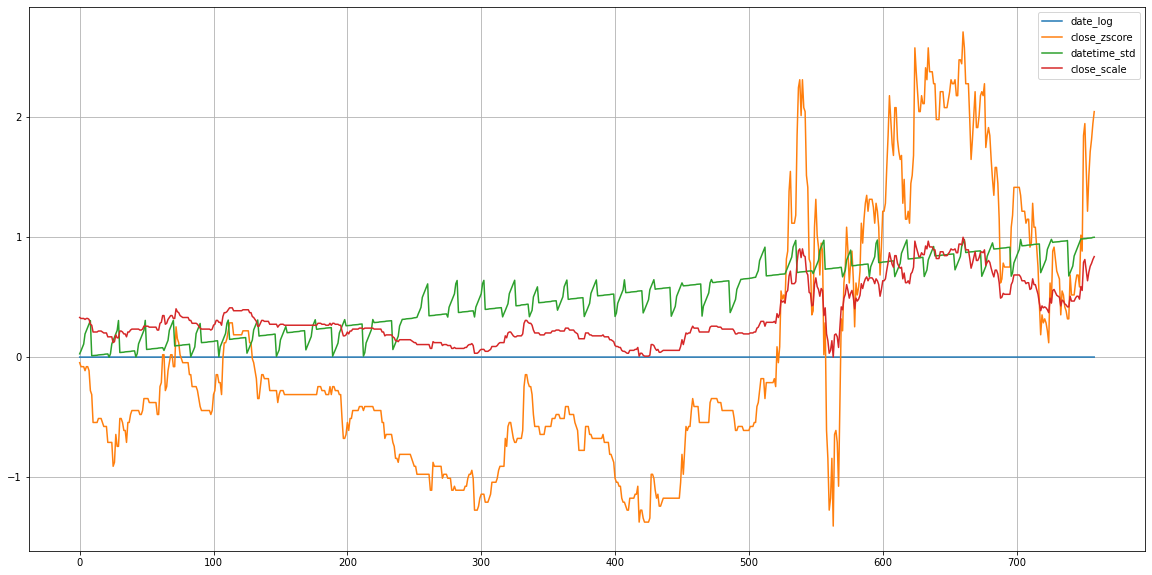

In [644]:
final_df_1.plot(figsize=(20,10), grid=True);

 Are the segments similar for different time series you analysed?

Yes

3. Prediction. Chose one of the transformed and normalised time series as a target 𝑔(𝑡) and other 3 as
supporting data 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡), where 𝑡 = 1, … , 𝑇. Provide scatter diagrams of (g(t),g(t+1)).
Evaluate the error of the “next-day forecast”, 𝑔̂(𝑡 + 1) = 𝑔(𝑡).
Use data for 2018 as the training set and find the predictor of 𝑔(𝑡 + 1) (the next day value) as a
linear function Ψ of 𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡):
𝑔̂(𝑡 + 1) = Ψ(𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡)) (1)
(linear regression). Evaluate the training set error. Use data for 2019 as a test set and evaluate the test
set error for this set. Also, use data for 2020 as a test set and evaluate the test set error for this set.
Compare these errors. Compare these errors to the errors of the “next-day forecast”. Comment.
Provide plots of 𝑔(𝑡), 𝑔̂(𝑡), and the residual. Present the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram. (30 marks) 

In [645]:
final_df_1["Date"] = df1_norm.Date.astype(int).astype(str).apply(lambda x: x[0:4])

In [646]:
final_df_1.head()

,date_log,close_zscore,datetime_std,close_scale,Date
0,0.000000,-0.046485,0.027447,0.330645,2018
1,0.000033,-0.079739,0.053065,0.322581,2018
2,0.000033,-0.079739,0.081427,0.322581,2018
3,0.000033,-0.079739,0.108875,0.322581,2018
4,0.000085,-0.112993,0.193047,0.314516,2018


Use data for 2018 as the training set and find the predictor of 𝑔(𝑡 + 1) (the next day value) as a linear function Ψ of 𝑔(𝑡), 𝑑1 (𝑡), 𝑑2 (𝑡), 𝑑3 (𝑡): 𝑔̂(𝑡 + 1) = Ψ(𝑔(𝑡), 𝑑1 (𝑡), 𝑑2 (𝑡), 𝑑3 (𝑡)) (1) (linear regression).

In [647]:
train = final_df_1.loc[final_df_1["Date"] == "2018"]
test  = final_df_1.loc[final_df_1["Date"] != "2018"] 

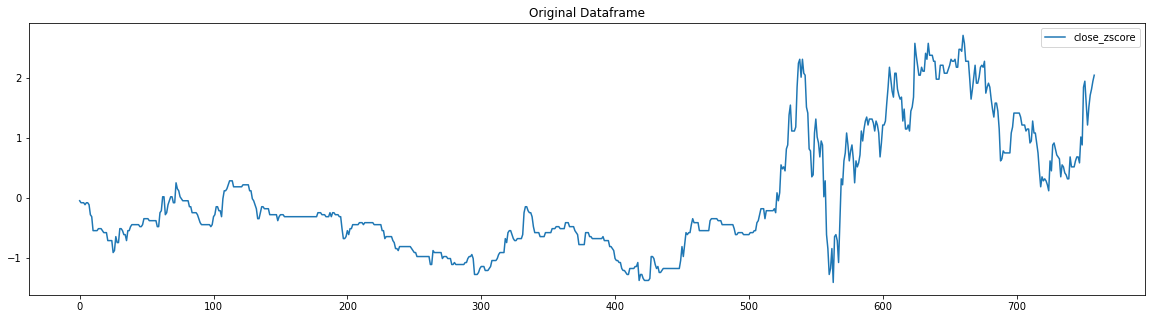

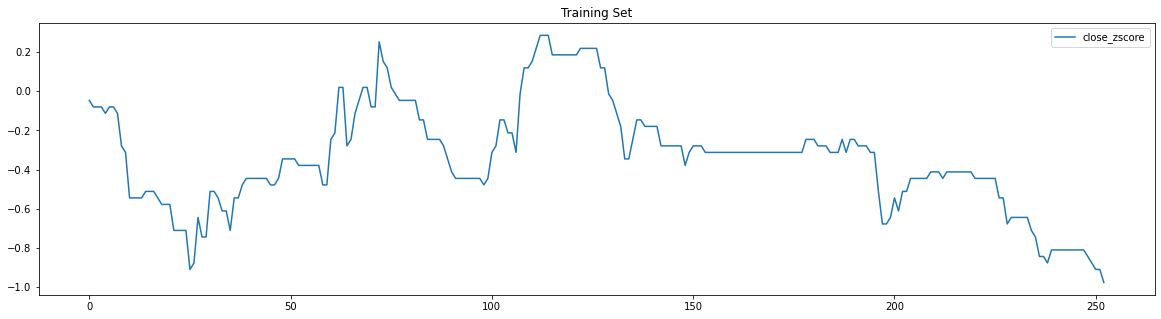

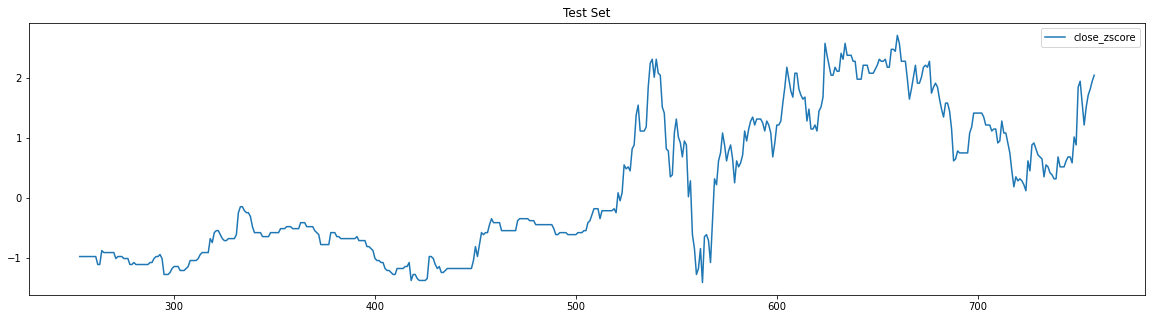

In [648]:
final_df_1.plot(y="close_zscore", figsize=(20,5),title="Original Dataframe")
train.plot(y="close_zscore", figsize=(20,5),title="Training Set")
test.plot(y="close_zscore", figsize=(20,5),title="Test Set");

In [649]:
X = train[['date_log', 'datetime_std', 'close_scale']]
Y = train['close_zscore'].values

In [650]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [651]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict the test data
y_pred_lr_new = lr.predict(X_test)

#evaulation of the lr   
print('Intercept:', lr.intercept_)
print('Coefficients:', lr.coef_)

Intercept: -1.4098944240754268
Coefficients: [-2.81818249e-13  0.00000000e+00  4.12348116e+00]


In [652]:
# Linear regressor evaulation parameters
df_linear = evaulation('linear', y_pred_lr_new, y_test)
df_linear

,linear
Exp_Var_Score,1.000000e+00
Max_Error,8.881784e-16
MSE,1.953501e-31
MAE,2.717125e-16
R2_Score,1.000000e+00
Median_Abs_Error,1.110223e-16


Use data for 2019 as a test set and evaluate the test set error for this set. Also, use data for 2020 as a test set and evaluate the test set error for this set. Compare these errors.

In [653]:
# predict 2019-2020
x = test[['date_log', 'datetime_std', 'close_scale']]
y = test['close_zscore'].values

In [654]:
new_preds = lr.predict(x)

In [655]:
# Linear regressor evaulation parameters
df_linear = evaulation('linear', new_preds, y)
df_linear

,linear
Exp_Var_Score,1.000000e+00
Max_Error,3.108624e-15
MSE,1.278596e-30
MAE,8.789768e-16
R2_Score,1.000000e+00
Median_Abs_Error,8.881784e-16


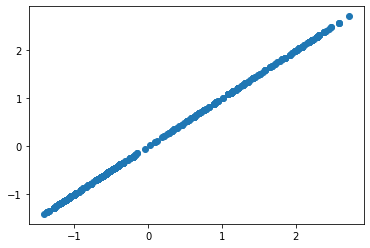

In [656]:
plt.scatter(y, new_preds);

Provide plots of 𝑔(𝑡), 𝑔̂(𝑡), and the residual. Present the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram. (30 marks)

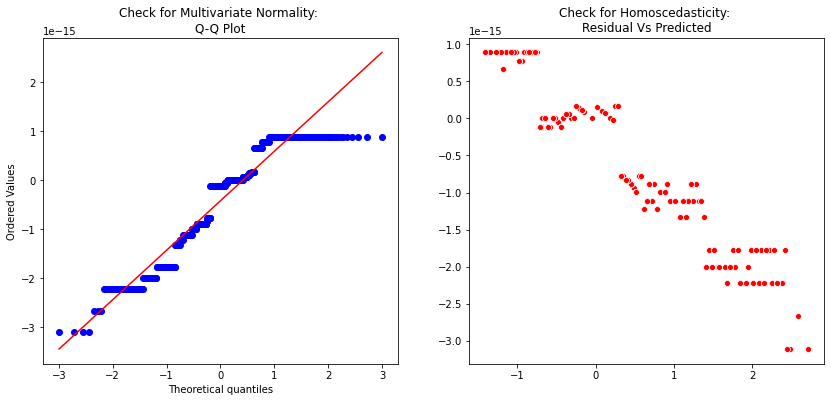

In [657]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y - new_preds),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y - new_preds), x= new_preds, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Answer : based on suggestions from questions, I trained my linear regression model using data from 2018, then made predictions for the next 2 years (2019 & 2020). As seen in the residual visualization above, my model can predict accurately.

4. Adaptive predictors. For each given value of the “frame width”, Δ=5, 10, 30, create and test the
following adaptive predictor. For every T> Δ create the training set with Δ input vectors
(𝑔(𝑡), 𝑑1
(𝑡), 𝑑2
(𝑡), 𝑑3
(𝑡)) (𝑡 = 𝑇 − Δ, … , 𝑇-1) and the corresponding outputs 𝑔(𝑡 + 1).
In more detail, the input vectors 𝒙𝑖
 and the output values 𝑦𝑖
 for a given T are
𝒙1 = (𝑔(𝑇 − Δ), 𝑑1
(𝑇 − Δ), 𝑑2
(𝑇 − Δ), 𝑑3
(𝑇 − Δ)), 𝑦1 = 𝑔(𝑇 − Δ + 1)
………..
𝒙𝑖 = (𝑔(𝑇 − Δ + 𝑖 − 1), 𝑑1
(𝑇 − Δ + 𝑖 − 1), 𝑑2
(𝑇 − Δ + 𝑖 − 1), 𝑑3
(𝑇 − Δ + 𝑖 − 1)),
𝑦𝑖 = 𝑔(𝑇 − Δ + 𝑖)
Where i=1,2,…, Δ.
Find the linear regression (1) for each T> Δ. Test this linear regression for the next time value, t=T+1.
In more detail, for each T there is one test example with the input vector 𝒙𝑡𝑒𝑠𝑡 and output value 𝑦𝑡𝑒𝑠𝑡:
𝒙𝑡𝑒𝑠𝑡 = (𝑔(𝑇), 𝑑1
(𝑇), 𝑑2
(𝑇), 𝑑3
(𝑇)), 𝑦𝑡𝑒𝑠𝑡 = 𝑔(𝑇 + 1)
Please pay attention that this example does not belong to a training set for this value of T.
 Find the residuals at these test time moments. Plot these residuals and the values 𝑔(𝑡), 𝑔̂(𝑡). Present
the (𝑔(𝑡), 𝑔̂(𝑡)) scatter diagram (t=T+1). Calculate the mean square error. Compare to the previous
task. Comment. (30 marks) 

In [658]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

In [659]:
# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

In [660]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,-1.409894e+00,-1.409894e+00
1,theta_1,date_log,2.910383e-11,-2.818182e-13
2,theta_2,datetime_std,1.332268e-14,0.000000e+00
3,theta_3,close_scale,4.123481e+00,4.123481e+00


In [661]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  2.3609508910467116e-28
R square obtain for normal equation method is : 1.0


In [662]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse_sk)
print('R square obtain for scikit learn library is :',R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  1.9535011520121478e-31
R square obtain for scikit learn library is : 1.0


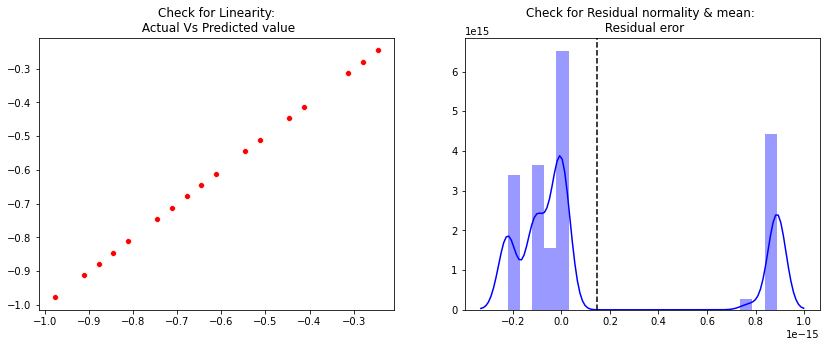

In [663]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

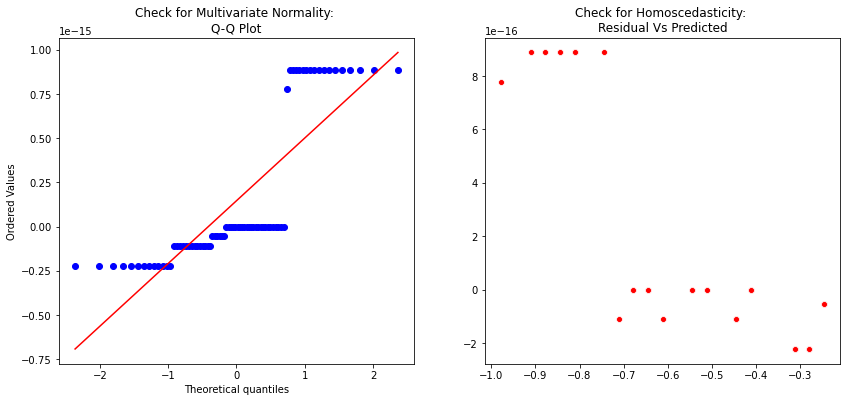

In [664]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Conclusion, based on the comparison of the residual visualization results on task 3 and 4, the visualization in task 4 look less than in task 3.